# Impacts of Greenhouse Gas (GHG) Emissions and Anthropogenic Aerosols on ENSO Characteristics

**Author:** Nicholas Ruprecht, MS Weather & Climate Risk & Data Analytics Student at The University of Illinois Urbana–Champaign  
**Mentor:** Dr. Zhuo Wang  

---

## Abstract
This study investigates how greenhouse gas (GHG) emissions and anthropogenic aerosols (AAER) influence the characteristics of the El Niño–Southern Oscillation (ENSO). Observational SST data from NOAA’s ERSSTv5 are combined with CESM2 Single-Forcing Large Ensemble experiments (LENS2, GHG2, AAER2) to classify ENSO events and construct DJF composites across multiple historical windows.  

ENSO classification is based on the **r–θ framework** for event identification, building on the parameterization approaches of **Zhiyuan et al. (2019)** and **Ham et al. (2019)**. This method applies percentile-based thresholds to distinguish El Niño and La Niña phases, enabling a consistent comparison between observations and model ensembles.  

For each CESM2 experiment, **at least 10 ensemble member simulations** were utilized to ensure robust statistics and capture internal variability. Composite SST anomalies are generated by averaging event years relative to climatology, with CESM2 POP grid outputs regridded to the observational 1°×1° grid using xESMF or scipy.griddata. Ensemble-mean composites are then compared across experiments to assess changes in ENSO frequency, amplitude, and spatial structure under different forcing scenarios.  

This work draws on **Simpson et al. (2023)** for context on CESM2 single-forcing ensemble design and ENSO diagnostics in the Pacific, and **Leupold et al. (2023)** for composite-based approaches to internal SST variability. Together, these references provide a foundation for understanding how external forcings reshape ENSO dynamics.

---

## Outline
1. **Data Sources**
   - Observational SSTs: NOAA ERSSTv5  
   - Model Data: CESM2 Single-Forcing Large Ensemble (LENS2, GHG2, AAER2)  
   - At least 10 ensemble members per CESM2 experiment  

2. **Methodology**
   - ENSO classification using r–θ framework (Zhiyuan et al. 2019; Ham et al. 2019)  
   - Percentile-based thresholding (top 60% r values)  
   - Seasonal DJF composites relative to climatology  
   - Regridding CESM2 POP outputs to observational grid  

3. **Analysis**
   - ENSO type frequencies across scenarios (GHG2, AAER2, LENS2, Observations)  
   - Normalized vs. unnormalized frequency comparisons  
   - Divergence metrics (KL, Jensen–Shannon) between models and observations  
   - Composite SST anomaly maps across historical windows  

4. **Objective**
   - Quantify the impacts of GHG emissions and anthropogenic aerosols on ENSO characteristics  
   - Assess changes in ENSO frequency, amplitude, and spatial structure under different forcing scenarios  

---

## References
- Zhiyuan, et al. (2019). *A unified complex index to characterize two types of ENSO simultaneously*  
- Ham, et al. (2019). *Deep learning for multi-year ENSO forecasts.*  
- Simpson, et al. (2023). *The CESM2 Single-Forcing Large Ensemble and Comparison to CESM1: Implications for Experimental Design.* Journal of Climate, 36(17), 5687–5711. DOI: [10.1175/JCLI-D-22-0666.1](https://doi.org/10.1175/JCLI-D-22-0666.1)  
- Leupold, et al. (2023). *El Niño–Southern Oscillation and internal sea surface temperature variability in the tropical Indian Ocean since 1675.*  

---

 # Library Imports
Loads essential Python libraries for data handling, analysis, visualization, and file management. These tools provide the foundation for working with climate datasets and producing plots.


In [1]:
import os
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# ENSO Classification Functions
Defines helper functions to calculate the Unified Complex ENSO Index (UCEI) and classify ENSO events. Computes amplitude and phase from Niño3/Niño4 anomalies, applies a DJF-based threshold, and assigns each event to El Niño or La Niña categories.



In [2]:
def calculate_ucei_model(data):
    real_part = data['Model_Nino3'] + data['Model_Nino4']
    imag_part = data['Model_Nino3'] - data['Model_Nino4']
    r = np.sqrt(real_part**2 + imag_part**2)
    theta = np.arctan2(imag_part, real_part)
    data['r'] = r
    data['theta'] = theta
    return r, theta

def classify_enso_model(data):
    r, theta = calculate_ucei_model(data)
    theta_deg = (np.degrees(theta) + 360) % 360  # wrapping to 0–360°

    data.loc[:, 'r'] = r
    data.loc[:, 'theta'] = theta
    data.loc[:, 'theta_deg'] = theta_deg
    data.loc[:, 'ENSO_Type_Model'] = 'None'

    # Filtering DJF months (Dec, Jan, Feb) for threshold calculation
    djf_mask = data['Month'].isin([12, 1, 2])
    r_djf_std = data.loc[djf_mask, 'r'].std()

    # Threshold based on DJF std
    mask = r >= r_djf_std
    data.loc[mask, 'ENSO_Type_Model'] = np.select(
        [
            (theta_deg[mask] > 15) & (theta_deg[mask] < 90),
            (theta_deg[mask] > 345) | (theta_deg[mask] < 15),
            (theta_deg[mask] > 270) & (theta_deg[mask] < 345),
            (theta_deg[mask] > 195) & (theta_deg[mask] < 270),
            (theta_deg[mask] > 165) & (theta_deg[mask] < 195),
            (theta_deg[mask] > 90) & (theta_deg[mask] < 165)
        ],
        ['EP El Nino', 'Mixed El Nino', 'CP El Nino',
         'EP La Nina', 'Mixed La Nina', 'CP La Nina'],
        default='None'
    )

    return data

# Observational SST Data Preparation
Loads observational SST data, extracts Niño3 and Niño4 regional averages, and standardizes them. Builds a DataFrame with dates and adds a month column for DJF thresholding in ENSO classification.



In [3]:
# Loading observational SST data
sst_data = xr.open_dataset('sst.mnmean.nc')

# Defining regions
nino3 = sst_data.sel(lat=slice(5, -5), lon=slice(270, 330))['sst'].mean(dim=['lat', 'lon'])
nino4 = sst_data.sel(lat=slice(5, -5), lon=slice(160, 210))['sst'].mean(dim=['lat', 'lon'])

# Creating DataFrame
data_obs = pd.DataFrame({
    'Date': pd.to_datetime(nino3['time'].values),
    'Model_Nino3': (nino3 - nino3.mean()) / nino3.std(),
    'Model_Nino4': (nino4 - nino4.mean()) / nino4.std()
})

# Adding Month column for DJF thresholding
data_obs['Month'] = data_obs['Date'].dt.month

# Synthetic ENSO Pattern Visualization
Generates idealized SST anomaly fields for different ENSO types and plots them with Cartopy. Highlights Niño3, Niño4, and Niño3.4 regions using labeled boxes to illustrate index definitions.



C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\2456729992.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 0.9, 0.95])


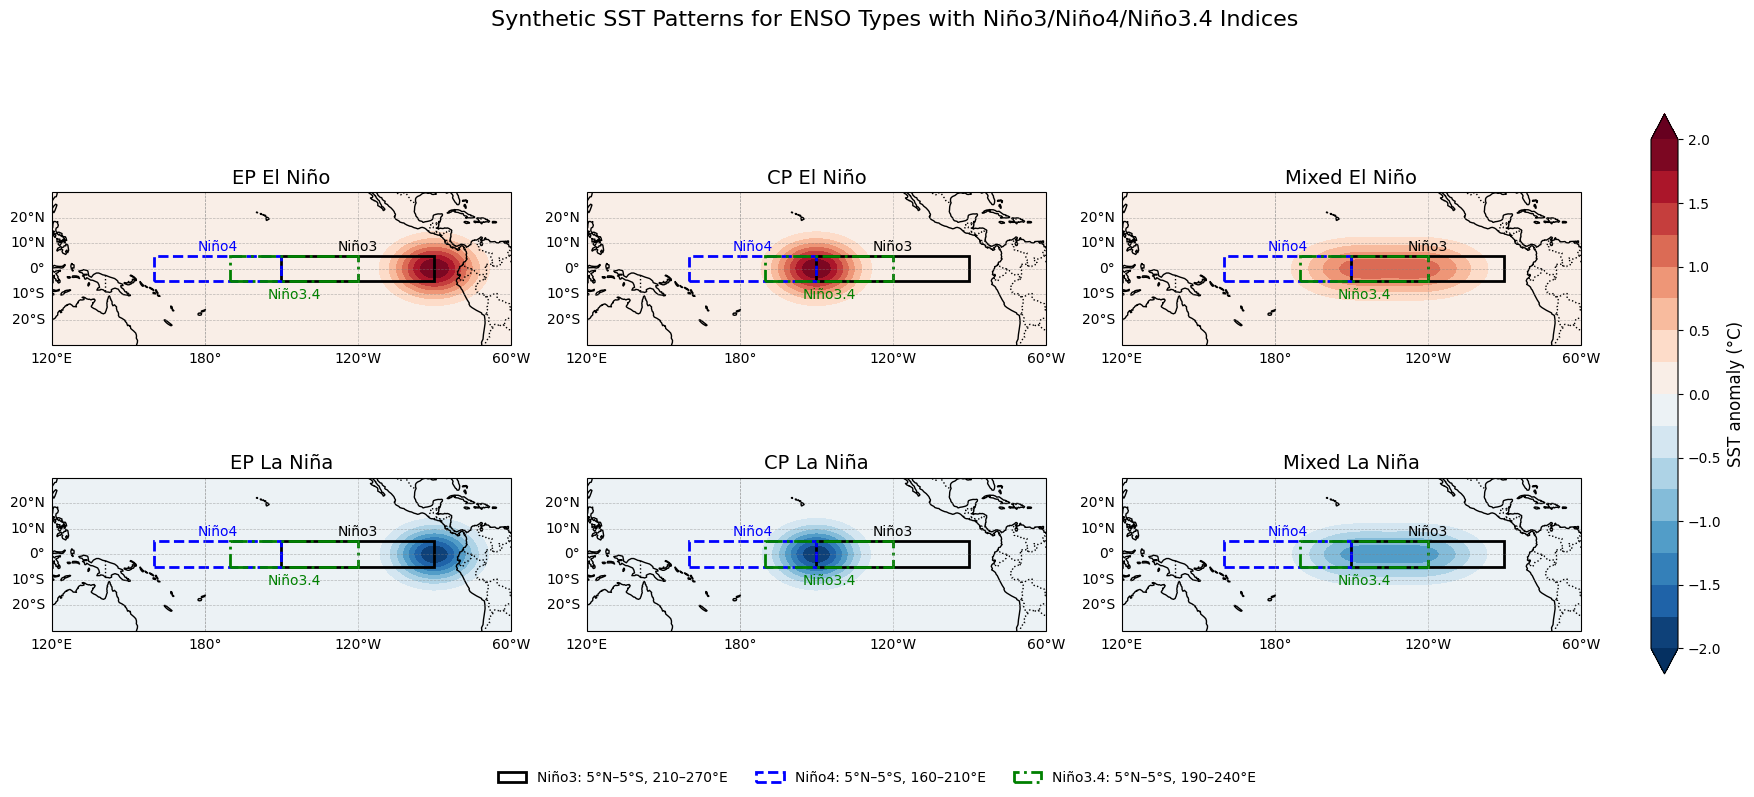

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle

# -------------------------
# Global plotting parameters (must be defined before use)
# -------------------------
plot_extent = [120, 300, -30, 30]     # Pacific view
levels = np.arange(-2.0, 2.05, 0.25)
cmap = 'RdBu_r'

# -------------------------
# Synthetic SST anomaly fields
# -------------------------
def generate_sst_pattern(enso_type):
    lon = np.linspace(plot_extent[0], plot_extent[1], 180)
    lat = np.linspace(plot_extent[2], plot_extent[3], 60)
    lon2d, lat2d = np.meshgrid(lon, lat)

    sst = np.zeros_like(lon2d)

    if enso_type == 'EP El Niño':
        sst += np.exp(-((lon2d - 270)/15)**2) * np.exp(-((lat2d)/10)**2) * 2
    elif enso_type == 'CP El Niño':
        sst += np.exp(-((lon2d - 210)/15)**2) * np.exp(-((lat2d)/10)**2) * 2
    elif enso_type == 'Mixed El Niño':
        sst += (np.exp(-((lon2d - 240)/20)**2) + np.exp(-((lon2d - 210)/20)**2)) * np.exp(-((lat2d)/10)**2)
    elif enso_type == 'EP La Niña':
        sst -= np.exp(-((lon2d - 270)/15)**2) * np.exp(-((lat2d)/10)**2) * 2
    elif enso_type == 'CP La Niña':
        sst -= np.exp(-((lon2d - 210)/15)**2) * np.exp(-((lat2d)/10)**2) * 2
    elif enso_type == 'Mixed La Niña':
        sst -= (np.exp(-((lon2d - 240)/20)**2) + np.exp(-((lon2d - 210)/20)**2)) * np.exp(-((lat2d)/10)**2)

    return lon, lat, sst

# -------------------------
# Plotting
# -------------------------
enso_types = ['EP El Niño', 'CP El Niño', 'Mixed El Niño',
              'EP La Niña', 'CP La Niña', 'Mixed La Niña']

fig, axes = plt.subplots(2, 3, figsize=(18, 8),
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

for ax, etype in zip(axes.flat, enso_types):
    lon, lat, sst = generate_sst_pattern(etype)
    lon2d, lat2d = np.meshgrid(lon, lat)

    im = ax.contourf(lon2d, lat2d, sst, levels=levels,
                     cmap=cmap, extend='both', transform=ccrs.PlateCarree())
    ax.set_title(etype, fontsize=14)
    ax.set_extent(plot_extent, crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Axis labels
    ax.set_xlabel("Longitude (°E)")
    ax.set_ylabel("Latitude (°N)")

    # Niño3 box
    ax.add_patch(Rectangle((210, -5), 60, 10, edgecolor='black',
                           facecolor='none', lw=2, label='Niño3', transform=ccrs.PlateCarree()))
    ax.text(240, 7, "Niño3", ha='center', fontsize=10, transform=ccrs.PlateCarree())

    # Niño4 box
    ax.add_patch(Rectangle((160, -5), 50, 10, edgecolor='blue',
                           facecolor='none', lw=2, linestyle='--', label='Niño4', transform=ccrs.PlateCarree()))
    ax.text(185, 7, "Niño4", ha='center', fontsize=10, color='blue', transform=ccrs.PlateCarree())

    # Niño3.4 box
    ax.add_patch(Rectangle((190, -5), 50, 10, edgecolor='green',
                           facecolor='none', lw=2, linestyle='-.', label='Niño3.4', transform=ccrs.PlateCarree()))
    ax.text(215, -12, "Niño3.4", ha='center', fontsize=10, color='green', transform=ccrs.PlateCarree())

# Shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label('SST anomaly (°C)', fontsize=12)

# Legend for index boxes
legend_elements = [
    Rectangle((0,0),1,1, edgecolor='black', facecolor='none', lw=2, label='Niño3: 5°N–5°S, 210–270°E'),
    Rectangle((0,0),1,1, edgecolor='blue', facecolor='none', lw=2, linestyle='--', label='Niño4: 5°N–5°S, 160–210°E'),
    Rectangle((0,0),1,1, edgecolor='green', facecolor='none', lw=2, linestyle='-.', label='Niño3.4: 5°N–5°S, 190–240°E')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=10, frameon=False)

plt.suptitle("Synthetic SST Patterns for ENSO Types with Niño3/Niño4/Niño3.4 Indices", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 0.9, 0.95])

# --- Saving figure to directory ---
plt.savefig("block4_synthetic_sst_patterns.png", dpi=300)

plt.show()

# Ensemble Processing
Defines a function to process climate model ensemble members by extracting Niño3 and Niño4 SST anomalies. Standardizes values, classifies ENSO phases, assigns seasons, and organizes results for each ensemble member.



In [5]:
# === Ensemble Processing ===
def process_ensemble_frequencies(base_path, label, ensemble_range):
    from collections import defaultdict
    import os
    import xarray as xr
    import pandas as pd

    ensemble_files = defaultdict(list)
    for f in os.listdir(base_path):
        if label in f and f.endswith('.nc'):
            for i in ensemble_range:
                if f'.{str(i).zfill(3)}.' in f:
                    ensemble_files[i].append(f)

    member_classifications = {}

    for ens_num, files in ensemble_files.items():
        try:
            dfs = []

            for f in sorted(files):
                ds = xr.open_dataset(os.path.join(base_path, f), decode_times=True, decode_timedelta=True)

                if 'SST' not in ds:
                    continue

                # Handling lat/lon or TLAT/TLONG
                if 'lat' in ds.coords and 'lon' in ds.coords:
                    lat = ds['lat']
                    lon = ds['lon']
                    dims = ['lat', 'lon']
                elif 'TLAT' in ds and 'TLONG' in ds:
                    lat = ds['TLAT']
                    lon = ds['TLONG']
                    dims = ['nlat', 'nlon']
                else:
                    raise KeyError("No recognizable lat/lon coordinates")

                lat2d, lon2d = xr.broadcast(lat, lon)

                mask_nino3 = ((lat2d >= -5) & (lat2d <= 5)) & ((lon2d >= 210) & (lon2d <= 270))
                mask_nino4 = ((lat2d >= -5) & (lat2d <= 5)) & ((lon2d >= 160) & (lon2d <= 210))

                nino3 = ds['SST'].where(mask_nino3).mean(dim=dims)
                nino4 = ds['SST'].where(mask_nino4).mean(dim=dims)

                raw_time = nino3['time'].values
                time_index = pd.to_datetime([str(t) for t in raw_time])

                df = pd.DataFrame({
                    'Date': time_index,
                    'Model_Nino3': ((nino3 - nino3.mean()) / nino3.std()).values.squeeze(),
                    'Model_Nino4': ((nino4 - nino4.mean()) / nino4.std()).values.squeeze()
                })

                dfs.append(df)

            if not dfs:
                continue

            df = pd.concat(dfs).sort_values('Date').reset_index(drop=True)

            # Adding Month column for DJF thresholding
            df['Month'] = df['Date'].dt.month

            # 🔄 Classify ENSO using internal DJF std threshold
            df = classify_enso_model(df)

            # Assigning season
            df['Season'] = pd.cut(df['Month'] % 12 + 1,
                                  bins=[0, 3, 6, 9, 12],
                                  labels=['DJF', 'MAM', 'JJA', 'SON'],
                                  ordered=False)

            df['Ensemble_Member'] = ens_num
            member_classifications[ens_num] = df

        except Exception as e:
            print(f"Skipping ensemble {ens_num} in {label} due to error: {e}")
            continue

    return member_classifications

# Running Ensemble Analysis
Executes the ensemble processing function for GHG, AAER, and LENS experiments. Loads multiple ensemble members from the specified directory and applies ENSO classification to each set.



In [6]:
# Running ensemble analysis
base_path = r'C:\Users\nickr\Desktop\Indexes Capstone\\'
ensemble_range = range(1, 11)

ghg_members = process_ensemble_frequencies(base_path, 'CESM2-SF-GHG', ensemble_range)
aaer_members = process_ensemble_frequencies(base_path, 'CESM2-SF-AAER', ensemble_range)
lens_members = process_ensemble_frequencies(base_path, 'LE2', ensemble_range)

# Time Coverage Diagnostics
Checks the temporal span of each ensemble member and observational dataset. Prints start and end dates, then aligns observations to the model time window for consistent comparison.



In [7]:
# === Time Coverage Diagnostics ===
def print_time_coverage(member_dict, label):
    print(f"\n=== Time Coverage for {label} ===")
    for member_id, df in member_dict.items():
        start = df['Date'].min()
        end = df['Date'].max()
        print(f"Member {str(member_id).zfill(3)}: {start.date()} to {end.date()}")

print_time_coverage(ghg_members, 'GHG2')
print_time_coverage(aaer_members, 'AAER2')
print_time_coverage(lens_members, 'LENS2')

start_obs = data_obs['Date'].min()
end_obs = data_obs['Date'].max()
print(f"\n=== Observational Data Time Coverage ===")
print(f"Observations: {start_obs.date()} to {end_obs.date()}")

# === Aligning Observational Data to Model Time Window ===
data_obs_aligned = data_obs[(data_obs['Date'] >= '1850-02-01') & (data_obs['Date'] <= '2015-01-01')].copy()


=== Time Coverage for GHG2 ===
Member 001: 1850-02-01 to 2015-01-01
Member 002: 1850-02-01 to 2015-01-01
Member 003: 1850-02-01 to 2015-01-01
Member 004: 1850-02-01 to 2015-01-01
Member 005: 1850-02-01 to 2015-01-01
Member 006: 1850-02-01 to 2015-01-01
Member 007: 1850-02-01 to 2015-01-01
Member 008: 1850-02-01 to 2015-01-01
Member 009: 1850-02-01 to 2015-01-01
Member 010: 1850-02-01 to 2015-01-01

=== Time Coverage for AAER2 ===
Member 001: 1850-02-01 to 2015-01-01
Member 002: 1850-02-01 to 2015-01-01
Member 003: 1850-02-01 to 2015-01-01
Member 004: 1850-02-01 to 2015-01-01
Member 005: 1850-02-01 to 2015-01-01
Member 006: 1850-02-01 to 2015-01-01
Member 007: 1850-02-01 to 2015-01-01
Member 008: 1850-02-01 to 2015-01-01
Member 009: 1850-02-01 to 2015-01-01
Member 010: 1850-02-01 to 2015-01-01

=== Time Coverage for LENS2 ===
Member 001: 1850-02-01 to 2015-01-01
Member 002: 1850-02-01 to 2015-01-01
Member 003: 1850-02-01 to 2015-01-01
Member 004: 1850-02-01 to 2015-01-01
Member 005: 18

# Global Normalization of Ensemble Members
Defines a function to normalize Niño3 and Niño4 anomalies across all ensemble members. Standardizes values using global means and standard deviations, then reclassifies ENSO events consistently for each experiment.


In [8]:
# Defining the normalization function
def normalize_members_globally(member_dict):
    all_df = pd.concat([df for df in member_dict.values()])
    mean_nino3 = all_df['Model_Nino3'].mean()
    std_nino3 = all_df['Model_Nino3'].std()
    mean_nino4 = all_df['Model_Nino4'].mean()
    std_nino4 = all_df['Model_Nino4'].std()

    normalized_members = {}
    for member_id, df in member_dict.items():
        df_norm = df.copy()
        df_norm['Model_Nino3'] = (df_norm['Model_Nino3'] - mean_nino3) / std_nino3
        df_norm['Model_Nino4'] = (df_norm['Model_Nino4'] - mean_nino4) / std_nino4

        # Adding Month column for DJF thresholding
        df_norm['Month'] = df_norm['Date'].dt.month

        # Classifying ENSO using DJF std threshold
        df_norm = classify_enso_model(df_norm)

        normalized_members[member_id] = df_norm

    return normalized_members

ghg_members_normalized = normalize_members_globally(ghg_members)
aaer_members_normalized = normalize_members_globally(aaer_members)
lens_members_normalized = normalize_members_globally(lens_members)

# Normalizing Observations with Model Statistics
Combines all ensemble data to compute global Niño3 and Niño4 normalization parameters. Applies these model-based statistics to observational data, adds a month column, and reclassifies ENSO events using the DJF threshold.



In [9]:
# Combining all model data to compute global normalization stats
all_model_df = pd.concat([*ghg_members.values(), *aaer_members.values(), *lens_members.values()])
mean_nino3 = all_model_df['Model_Nino3'].mean()
std_nino3 = all_model_df['Model_Nino3'].std()
mean_nino4 = all_model_df['Model_Nino4'].mean()
std_nino4 = all_model_df['Model_Nino4'].std()

# Normalizing observations using model stats
data_obs_aligned['Model_Nino3'] = (data_obs_aligned['Model_Nino3'] - mean_nino3) / std_nino3
data_obs_aligned['Model_Nino4'] = (data_obs_aligned['Model_Nino4'] - mean_nino4) / std_nino4

# Addding Month column for DJF thresholding
data_obs_aligned['Month'] = data_obs_aligned['Date'].dt.month

# Classifying ENSO using DJF std threshold
data_obs_aligned = classify_enso_model(data_obs_aligned)

# ENSO Frequency and Divergence Analysis
Calculates ENSO type frequencies across ensembles and observations, both for DJF and all months. Computes divergence metrics (KL and JS) to quantify differences between model scenarios and observations, saving results to CSV files.



In [10]:
# --- Frequency Functions ---
def average_member_counts(member_dict, enso_types):
    freqs = []
    for df in member_dict.values():
        classified = classify_enso_model(df.copy())
        classified = classified[classified['ENSO_Type_Model'] != 'None']
        freq = classified['ENSO_Type_Model'].value_counts(normalize=True).reindex(enso_types, fill_value=0)
        freqs.append(freq)
    return pd.DataFrame(freqs).mean()

def member_frequency_stats(member_dict, enso_types):
    freq_tables = []
    for df in member_dict.values():
        df_valid = df[df['ENSO_Type_Model'] != 'None']
        freq = df_valid['ENSO_Type_Model'].value_counts(normalize=True).reindex(enso_types, fill_value=0)
        freq_tables.append(freq)
    freq_df = pd.DataFrame(freq_tables)
    return freq_df.mean().mul(100), freq_df.std().mul(100)

# --- Divergence Functions ---
def classify_and_count(df, enso_types):
    classified = classify_enso_model(df.copy())
    classified = classified[classified['ENSO_Type_Model'] != 'None']
    return classified['ENSO_Type_Model'].value_counts(normalize=True).reindex(enso_types, fill_value=0)

def compute_divergence(obs_freq, model_freq):
    from scipy.spatial.distance import jensenshannon
    from scipy.stats import entropy
    kl = entropy(obs_freq + 1e-10, model_freq + 1e-10)
    js = jensenshannon(obs_freq, model_freq)
    return kl, js

# --- ENSO Types ---
enso_types = ['EP El Nino', 'Mixed El Nino', 'CP El Nino',
              'EP La Nina', 'Mixed La Nina', 'CP La Nina']

# --- Divergence using DJF std threshold ---
lens_mean, lens_std = member_frequency_stats(lens_members_normalized, enso_types)
obs_freq = classify_and_count(data_obs_aligned, enso_types)

for label, members in [('GHG2', ghg_members_normalized),
                       ('AAER2', aaer_members_normalized),
                       ('LENS2', lens_members_normalized)]:
    model_freq = average_member_counts(members, enso_types)
    kl, js = compute_divergence(obs_freq.values, model_freq.values)
    print(f"{label} vs Observations — KL: {kl:.3f}, JS: {js:.3f}")

# --- DJF ENSO Frequencies ---
def filter_djf(df):
    df = df.copy()
    df['Month'] = df['Date'].dt.month
    df['Season'] = pd.cut(df['Month'] % 12 + 1,
                          bins=[0, 3, 6, 9, 12],
                          labels=['DJF', 'MAM', 'JJA', 'SON'],
                          ordered=False)
    return df[df['Season'] == 'DJF']

def average_member_frequencies(member_dict, enso_types):
    freqs = []
    for df in member_dict.values():
        df_valid = df[df['ENSO_Type_Model'] != 'None']
        freq = df_valid['ENSO_Type_Model'].value_counts(normalize=True).reindex(enso_types, fill_value=0)
        freqs.append(freq)
    return pd.DataFrame(freqs).mean().mul(100).round(2)

enso_by_scenario_djf = {
    'GHG2': average_member_frequencies({k: filter_djf(v) for k, v in ghg_members_normalized.items()}, enso_types),
    'AAER2': average_member_frequencies({k: filter_djf(v) for k, v in aaer_members_normalized.items()}, enso_types),
    'LENS2': average_member_frequencies({k: filter_djf(v) for k, v in lens_members_normalized.items()}, enso_types),
    'Observations': filter_djf(data_obs_aligned)['ENSO_Type_Model']
        .value_counts(normalize=True).reindex(enso_types, fill_value=0).mul(100).round(2)
}
enso_df_djf = pd.DataFrame(enso_by_scenario_djf)
enso_df_djf.T.to_csv('djf_enso_frequencies.csv')

# --- ENSO Type Frequencies (All Months) ---
enso_by_scenario_all = {
    'GHG2': average_member_frequencies(ghg_members_normalized, enso_types),
    'AAER2': average_member_frequencies(aaer_members_normalized, enso_types),
    'LENS2': average_member_frequencies(lens_members_normalized, enso_types),
    'Observations': data_obs_aligned[data_obs_aligned['ENSO_Type_Model'] != 'None']['ENSO_Type_Model']
        .value_counts(normalize=True).reindex(enso_types, fill_value=0).mul(100).round(2)
}
enso_df_all = pd.DataFrame(enso_by_scenario_all)
enso_df_all.T.to_csv('enso_type_frequencies_all_months.csv', index=True)
print("ENSO Type Frequencies (% across all months):")
display(enso_df_all.T.style.format("{:.2f}").set_caption("ENSO Type Frequency by Scenario (All Months)"))

GHG2 vs Observations — KL: 0.120, JS: 0.177
AAER2 vs Observations — KL: 0.083, JS: 0.148
LENS2 vs Observations — KL: 0.098, JS: 0.160
ENSO Type Frequencies (% across all months):


ENSO_Type_Model,EP El Nino,Mixed El Nino,CP El Nino,EP La Nina,Mixed La Nina,CP La Nina
GHG2,13.29,23.03,15.17,15.49,17.42,15.60
AAER2,14.45,20.59,16.11,16.68,15.54,16.63
LENS2,14.01,21.26,16.07,15.90,16.59,16.17
Observations,18.75,9.25,18.56,25.90,9.44,18.11


# LENS2 Member Inspection
Inspects the normalized output for a single LENS2 ensemble member. Allows verification of ENSO classifications and normalized Niño3/Niño4 values for consistency and accuracy.



In [11]:
# LENS2 Check
lens_members_normalized[1]


,Date,Model_Nino3,Model_Nino4,Month,r,theta,theta_deg,ENSO_Type_Model,Season,Ensemble_Member
0,1850-02-01,-0.252089,-0.334039,2,0.591829,3.002678,172.040750,None,DJF,1
1,1850-02-01,0.133905,-0.630252,2,0.911206,2.146845,123.005153,None,DJF,1
2,1850-03-01,0.270319,-0.314271,3,0.586241,1.645840,94.299677,None,MAM,1
3,1850-03-01,0.769712,-0.899581,3,1.674337,1.648439,94.448602,CP La Nina,MAM,1
4,1850-04-01,0.775301,-0.038376,4,1.097783,0.834856,47.833710,EP El Nino,MAM,1
...,...,...,...,...,...,...,...,...,...,...
3955,2014-11-01,-1.531144,-2.102417,11,3.678195,2.985648,171.065029,Mixed La Nina,SON,1
3956,2014-12-01,-0.209758,0.594757,12,0.891891,-1.124457,295.573384,None,DJF,1
3957,2014-12-01,-1.396379,-2.457359,12,3.997121,2.872937,164.607140,CP La Nina,DJF,1
3958,2015-01-01,-1.309726,-2.465951,1,3.948745,2.844430,162.973847,CP La Nina,DJF,1


# AAER2 Member Inspection
Inspects the normalized output for a single AAER2 ensemble member. Helps verify ENSO classifications and standardized Niño3/Niño4 anomalies for accuracy within the AAER experiment.



In [12]:
# AAER2 Check
aaer_members_normalized[1]

,Date,Model_Nino3,Model_Nino4,Month,r,theta,theta_deg,ENSO_Type_Model,Season,Ensemble_Member
0,1850-02-01,-0.350199,-0.527158,2,0.895024,2.942567,168.596679,None,DJF,1
1,1850-03-01,0.124412,-0.670608,3,0.964565,2.172758,124.489878,None,MAM,1
2,1850-04-01,0.429660,-0.607861,4,1.052714,1.740893,99.745809,None,MAM,1
3,1850-05-01,0.685073,-0.176746,5,1.000564,1.037888,59.466602,None,MAM,1
4,1850-06-01,0.696779,0.623681,6,1.322483,0.055301,3.168535,Mixed El Nino,JJA,1
...,...,...,...,...,...,...,...,...,...,...
1975,2014-09-01,-0.713075,-0.080651,9,1.014870,-2.468819,218.547070,None,SON,1
1976,2014-10-01,-0.934585,-0.241379,10,1.365073,-2.608945,210.518467,EP La Nina,SON,1
1977,2014-11-01,-0.822179,-0.191242,11,1.193777,-2.584735,211.905618,EP La Nina,SON,1
1978,2014-12-01,-0.713523,-0.090890,12,1.017227,-2.482894,217.740661,None,DJF,1


# GHG2 Member Inspection
Inspects the normalized output for a single GHG2 ensemble member. Helps verify ENSO classifications and standardized Niño3/Niño4 anomalies within the greenhouse gas forcing experiment.



In [13]:
# GHG2 Check
ghg_members_normalized[1]

,Date,Model_Nino3,Model_Nino4,Month,r,theta,theta_deg,ENSO_Type_Model,Season,Ensemble_Member
0,1850-02-01,1.501265,1.358044,2,2.862893,0.050047,2.867509,Mixed El Nino,DJF,1
1,1850-03-01,1.628426,0.907178,3,2.636188,0.277129,15.878321,EP El Nino,MAM,1
2,1850-04-01,1.760974,0.593546,4,2.628050,0.460301,26.373333,EP El Nino,MAM,1
3,1850-05-01,1.350446,0.500536,5,2.036782,0.430451,24.663027,EP El Nino,MAM,1
4,1850-06-01,0.261461,0.651658,6,0.992996,-0.403838,336.861814,None,JJA,1
...,...,...,...,...,...,...,...,...,...,...
1975,2014-09-01,-0.246514,0.435870,9,0.708170,-1.300115,285.508894,None,SON,1
1976,2014-10-01,-0.712226,-0.096385,10,1.016421,-2.490706,217.293058,None,SON,1
1977,2014-11-01,-0.529235,-0.241493,11,0.822689,-2.784279,200.472546,None,SON,1
1978,2014-12-01,-0.138475,0.112829,12,0.252609,-1.672495,264.173115,None,DJF,1


# Observational ENSO Classification with DJF Threshold
Defines functions to compute a DJF-based standard deviation threshold from observational data. Classifies ENSO events into El Niño and La Niña subtypes using Niño3 and Niño4 anomalies relative to that threshold.



In [14]:
# Observational Data Check
def compute_djf_std_threshold(df, index='Model_Nino3'):
    df = df.copy()
    df['Month'] = df['Date'].dt.month
    df_djf = df[df['Month'].isin([12, 1, 2])]
    return df_djf[index].std()

def classify_enso_type_djf_threshold(df):
    df = df.copy()
    threshold = compute_djf_std_threshold(df)

    conditions = [
        (df['Model_Nino3'] >= threshold) & (df['Model_Nino4'] >= threshold),
        (df['Model_Nino3'] >= threshold) & (df['Model_Nino4'] < threshold),
        (df['Model_Nino3'] < threshold) & (df['Model_Nino4'] >= threshold),
        (df['Model_Nino3'] <= -threshold) & (df['Model_Nino4'] <= -threshold),
        (df['Model_Nino3'] <= -threshold) & (df['Model_Nino4'] > -threshold),
        (df['Model_Nino3'] > -threshold) & (df['Model_Nino4'] <= -threshold)
    ]
    labels = [
        'El Nino (Mixed)',
        'El Nino (EP)',
        'El Nino (CP)',
        'La Nina (Mixed)',
        'La Nina (EP)',
        'La Nina (CP)'
    ]
    df['ENSO_Type_Model'] = np.select(conditions, labels, default='Neutral')
    return df

# Observational Data Check Display
Applies the DJF threshold-based ENSO classification to observational data, adds seasonal metadata, and ensures consistent column formatting. Displays the first rows to verify classification and structure.


In [15]:
# --- Observational Data Check Display ---

# Step 1: Copying observational data
obs_df = data_obs_aligned.copy()

# Step 2: Applying threshold-based ENSO classification
classified_obs = classify_enso_type_djf_threshold(obs_df)

# Step 3: Adding seasonal and ensemble metadata
classified_obs['Month'] = classified_obs['Date'].dt.month
classified_obs['Season'] = classified_obs['Month'].map({
    12: 'DJF', 1: 'DJF', 2: 'DJF',
    3: 'MAM', 4: 'MAM', 5: 'MAM',
    6: 'JJA', 7: 'JJA', 8: 'JJA',
    9: 'SON', 10: 'SON', 11: 'SON'
})
classified_obs['Ensemble_Member'] = 1  # Observations treated as single member

# Step 4: Renaming columns if needed (only if they exist)
if 'Nino3' in classified_obs.columns:
    classified_obs = classified_obs.rename(columns={'Nino3': 'Model_Nino3'})
if 'Nino4' in classified_obs.columns:
    classified_obs = classified_obs.rename(columns={'Nino4': 'Model_Nino4'})

# Step 5: Ensuring all expected columns are present
expected_cols = [
    'Date', 'Model_Nino3', 'Model_Nino4', 'Month',
    'ENSO_Type_Model', 'Season', 'Ensemble_Member'
]
# Addding optional columns if they exist
for col in ['r', 'theta', 'theta_deg']:
    if col in classified_obs.columns:
        expected_cols.append(col)

# Reordering and displaying
classified_obs = classified_obs[expected_cols]
print(classified_obs.head(10))

        Date  Model_Nino3  Model_Nino4  Month ENSO_Type_Model Season  \
0 1854-01-01     0.320602    -0.664800      1         Neutral    DJF   
1 1854-02-01     0.997107    -0.559245      2    El Nino (EP)    DJF   
2 1854-03-01     1.024164    -0.096901      3    El Nino (EP)    MAM   
3 1854-04-01     0.503396     0.358653      4         Neutral    MAM   
4 1854-05-01     0.066468     0.967135      5    El Nino (CP)    MAM   
5 1854-06-01     0.424626     0.662778      6         Neutral    JJA   
6 1854-07-01    -0.277117     0.665809      7         Neutral    JJA   
7 1854-08-01    -1.291385    -0.122028      8    La Nina (EP)    JJA   
8 1854-09-01    -1.221408     0.150951      9    La Nina (EP)    SON   
9 1854-10-01    -0.209779    -0.329424     10         Neutral    SON   

   Ensemble_Member         r     theta   theta_deg  
0                1  1.043786  1.906844  109.254108  
1                1  1.616773  1.296547   74.286654  
2                1  1.454855  0.879732   50.4049

# ENSO Frequency Analysis with DJF std(r) Threshold
Classifies ENSO events using the DJF-based standard deviation of the UCEI amplitude (r) and computes frequencies as a percentage of all months. Results are displayed in both tabular and stacked bar chart form, showing scenario comparisons without normalizing over classified months.

ENSO Type Frequency by Scenario (All Months)
Percent of total months (not normalized over classified months).
Values represent the percentage of all months assigned to each ENSO type.



,GHG2,AAER2,LENS2,Observations
ENSO_Type_Model,,,,
EP El Nino,9.32,10.68,10.43,15.31
Mixed El Nino,16.14,15.20,15.82,7.55
CP El Nino,10.65,11.91,11.98,15.16
EP La Nina,10.87,12.32,11.84,21.16
Mixed La Nina,12.22,11.48,12.35,7.71
CP La Nina,10.94,12.29,12.05,14.80


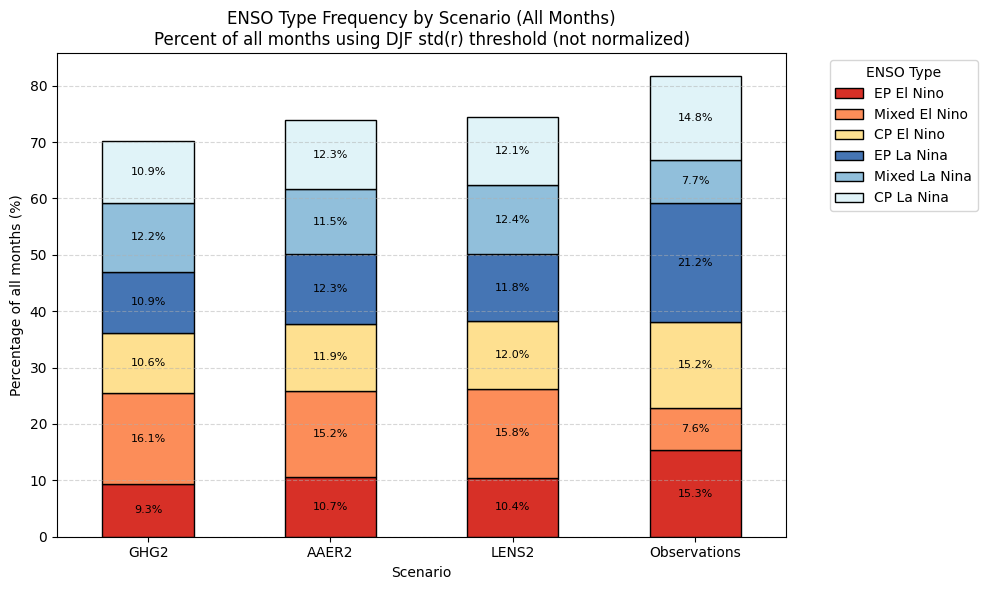

In [31]:
# --- Classification using DJF std(r) threshold ---
def classify_enso_model_djf_std(data):
    r, theta = calculate_ucei_model(data)
    theta_deg = (np.degrees(theta) + 360) % 360
    r_djf_std = r[data['Date'].dt.month.isin([12, 1, 2])].std()

    data = data.copy()
    data['r'] = r
    data['theta'] = theta
    data['theta_deg'] = theta_deg
    data['ENSO_Type_Model'] = 'None'

    mask = r >= r_djf_std
    data.loc[mask, 'ENSO_Type_Model'] = np.select(
        [
            (theta_deg[mask] > 15) & (theta_deg[mask] < 90),
            (theta_deg[mask] > 345) | (theta_deg[mask] < 15),
            (theta_deg[mask] > 270) & (theta_deg[mask] < 345),
            (theta_deg[mask] > 195) & (theta_deg[mask] < 270),
            (theta_deg[mask] > 165) & (theta_deg[mask] < 195),
            (theta_deg[mask] > 90) & (theta_deg[mask] < 165)
        ],
        ['EP El Nino', 'Mixed El Nino', 'CP El Nino',
         'EP La Nina', 'Mixed La Nina', 'CP La Nina'],
        default='None'
    )

    return data

# --- Computing ENSO frequencies as % of all months (not normalized over classified only) ---
def all_months_absolute_frequencies(member_dict, enso_types):
    freq_tables = []
    for df in member_dict.values():
        classified = classify_enso_model_djf_std(df.copy())
        total_months = len(classified)
        freq = classified['ENSO_Type_Model'].value_counts().reindex(enso_types, fill_value=0)
        freq = freq.div(total_months).mul(100).round(2)
        freq_tables.append(freq)
    freq_df = pd.DataFrame(freq_tables)
    return freq_df.mean().round(2)

# --- ENSO types ---
enso_types = ['EP El Nino', 'Mixed El Nino', 'CP El Nino',
              'EP La Nina', 'Mixed La Nina', 'CP La Nina']

# --- Classifying observations using DJF std(r) threshold ---
classified_obs_all = classify_enso_model_djf_std(data_obs_aligned.copy())
total_obs_months = len(classified_obs_all)

# --- Computing frequencies across all months (unnormalized) ---
enso_by_scenario_all_abs = {
    'GHG2': all_months_absolute_frequencies(ghg_members_normalized, enso_types),
    'AAER2': all_months_absolute_frequencies(aaer_members_normalized, enso_types),
    'LENS2': all_months_absolute_frequencies(lens_members_normalized, enso_types),
    'Observations': classified_obs_all['ENSO_Type_Model'].value_counts()
        .reindex(enso_types, fill_value=0).div(total_obs_months).mul(100).round(2)
}

enso_df_all_abs = pd.DataFrame(enso_by_scenario_all_abs)

# --- Printing with clarification ---
print("ENSO Type Frequency by Scenario (All Months)\n"
      "Percent of total months (not normalized over classified months).\n"
      "Values represent the percentage of all months assigned to each ENSO type.\n")

display(enso_df_all_abs)

# --- Plotting ENSO type frequencies (unnormalized: % of all months) ---
import matplotlib.pyplot as plt

enso_colors = {
    'EP El Nino': '#d73027',
    'Mixed El Nino': '#fc8d59',
    'CP El Nino': '#fee090',
    'EP La Nina': '#4575b4',
    'Mixed La Nina': '#91bfdb',
    'CP La Nina': '#e0f3f8'
}

fig, ax = plt.subplots(figsize=(10, 6))
enso_df_all_abs.T.plot(
    kind='bar',
    stacked=True,
    color=[enso_colors[col] for col in enso_df_all_abs.index],
    edgecolor='black',
    ax=ax
)

# --- Add percentage labels ---
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f"{height:.1f}%",
                ha='center',
                va='center',
                fontsize=8,
                color='black'
            )

ax.set_title('ENSO Type Frequency by Scenario (All Months)\nPercent of all months using DJF std(r) threshold (not normalized)')
ax.set_ylabel('Percentage of all months (%)')
ax.set_xlabel('Scenario')
ax.set_xticks(range(len(enso_df_all_abs.columns)))
ax.set_xticklabels(enso_df_all_abs.columns, rotation=0)
ax.legend(title='ENSO Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# --- Saving figure to directory ---
plt.savefig("block16_enso_frequencies_all_months_unnormalized.png", dpi=300)

plt.show()

# ENSO Frequency Analysis (Normalized over Classified Months)
Classifies ENSO events using the DJF-based std(r) threshold and computes frequencies as percentages of classified months only. Results are displayed in both tabular and stacked bar chart form, comparing scenarios against observations.

ENSO Type Frequency by Scenario (All Months)
Normalized over classified months using DJF std(r) threshold.
Values represent the percentage of classified months assigned to each ENSO type.



,GHG2,AAER2,LENS2,Observations
ENSO_Type_Model,,,,
EP El Nino,13.29,14.45,14.01,18.75
Mixed El Nino,23.03,20.59,21.26,9.25
CP El Nino,15.17,16.11,16.07,18.56
EP La Nina,15.49,16.68,15.90,25.90
Mixed La Nina,17.42,15.54,16.59,9.44
CP La Nina,15.60,16.63,16.17,18.11


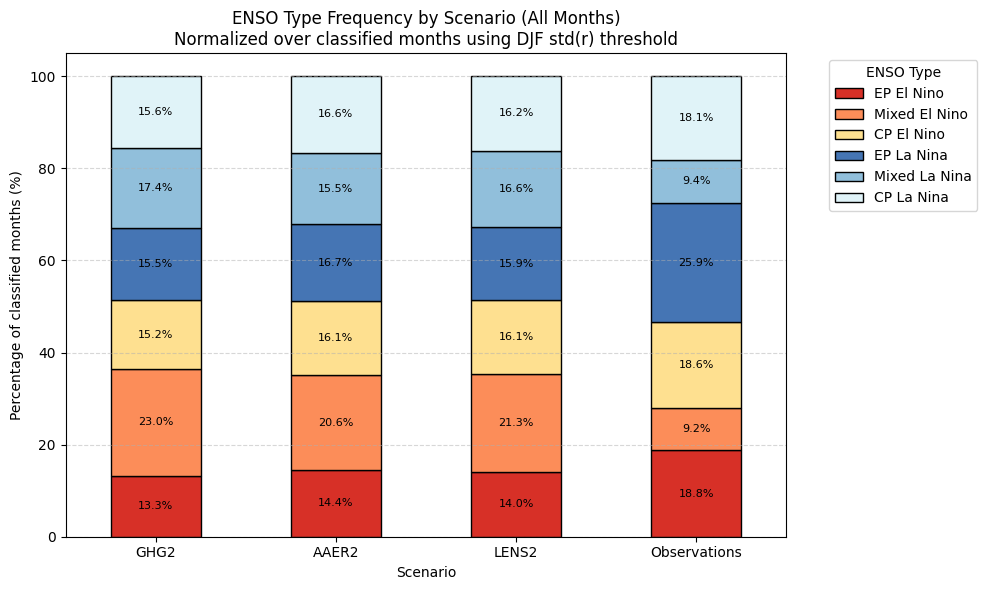

In [33]:
# --- Classification using DJF std(r) threshold ---
def classify_enso_model_djf_std(data):
    r, theta = calculate_ucei_model(data)
    theta_deg = (np.degrees(theta) + 360) % 360
    r_djf_std = r[data['Date'].dt.month.isin([12, 1, 2])].std()

    data = data.copy()
    data['r'] = r
    data['theta'] = theta
    data['theta_deg'] = theta_deg
    data['ENSO_Type_Model'] = 'None'

    mask = r >= r_djf_std
    data.loc[mask, 'ENSO_Type_Model'] = np.select(
        [
            (theta_deg[mask] > 15) & (theta_deg[mask] < 90),
            (theta_deg[mask] > 345) | (theta_deg[mask] < 15),
            (theta_deg[mask] > 270) & (theta_deg[mask] < 345),
            (theta_deg[mask] > 195) & (theta_deg[mask] < 270),
            (theta_deg[mask] > 165) & (theta_deg[mask] < 195),
            (theta_deg[mask] > 90) & (theta_deg[mask] < 165)
        ],
        ['EP El Nino', 'Mixed El Nino', 'CP El Nino',
         'EP La Nina', 'Mixed La Nina', 'CP La Nina'],
        default='None'
    )

    return data

# --- Computing average ENSO frequencies across all months using DJF std(r) threshold ---
def average_all_months_frequencies(member_dict, enso_types):
    freq_tables = []
    for df in member_dict.values():
        classified = classify_enso_model_djf_std(df.copy())
        df_valid = classified[classified['ENSO_Type_Model'] != 'None']
        freq = df_valid['ENSO_Type_Model'].value_counts(normalize=True).reindex(enso_types, fill_value=0)
        freq_tables.append(freq)
    freq_df = pd.DataFrame(freq_tables)
    return freq_df.mean().mul(100).round(2)

# --- ENSO types ---
enso_types = ['EP El Nino', 'Mixed El Nino', 'CP El Nino',
              'EP La Nina', 'Mixed La Nina', 'CP La Nina']

# --- Classifying observations using DJF std(r) threshold ---
classified_obs_all = classify_enso_model_djf_std(data_obs_aligned.copy())

# --- Computing frequencies across all months ---
enso_by_scenario_all = {
    'GHG2': average_all_months_frequencies(ghg_members_normalized, enso_types),
    'AAER2': average_all_months_frequencies(aaer_members_normalized, enso_types),
    'LENS2': average_all_months_frequencies(lens_members_normalized, enso_types),
    'Observations': classified_obs_all[classified_obs_all['ENSO_Type_Model'] != 'None']['ENSO_Type_Model']
        .value_counts(normalize=True).reindex(enso_types, fill_value=0).mul(100).round(2)
}

enso_df_all = pd.DataFrame(enso_by_scenario_all)

# --- Printing with clarification ---
print("ENSO Type Frequency by Scenario (All Months)\n"
      "Normalized over classified months using DJF std(r) threshold.\n"
      "Values represent the percentage of classified months assigned to each ENSO type.\n")

display(enso_df_all)

# --- Plotting ENSO type frequencies (normalized over classified months) ---
import matplotlib.pyplot as plt

enso_colors = {
    'EP El Nino': '#d73027',
    'Mixed El Nino': '#fc8d59',
    'CP El Nino': '#fee090',
    'EP La Nina': '#4575b4',
    'Mixed La Nina': '#91bfdb',
    'CP La Nina': '#e0f3f8'
}

fig, ax = plt.subplots(figsize=(10, 6))
enso_df_all.T.plot(
    kind='bar',
    stacked=True,
    color=[enso_colors[col] for col in enso_df_all.index],
    edgecolor='black',
    ax=ax
)

# --- Add percentage labels ---
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f"{height:.1f}%",
                ha='center',
                va='center',
                fontsize=8,
                color='black'
            )

ax.set_title('ENSO Type Frequency by Scenario (All Months)\nNormalized over classified months using DJF std(r) threshold')
ax.set_ylabel('Percentage of classified months (%)')
ax.set_xlabel('Scenario')
ax.set_xticks(range(len(enso_df_all.columns)))
ax.set_xticklabels(enso_df_all.columns, rotation=0)
ax.legend(title='ENSO Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# --- Saving figure to directory ---
plt.savefig("block17_enso_frequencies_all_months_normalized.png", dpi=300)

plt.show()

# Normalized DJF ENSO Frequency Analysis
Computes ENSO type frequencies during DJF months using the DJF std(r) threshold, normalized over classified months. Results are shown in both tabular and stacked bar chart form, comparing scenarios against observations.

DJF ENSO Type Frequency by Scenario (Normalized)
Normalized over classified DJF months using DJF std(r) threshold.
Values represent the percentage of classified DJF months assigned to each ENSO type.



,GHG2,AAER2,LENS2,Observations
ENSO_Type_Model,,,,
EP El Nino,0.76,1.06,1.10,21.05
Mixed El Nino,29.62,27.98,29.35,11.84
CP El Nino,8.17,10.85,10.49,10.79
EP La Nina,8.25,12.94,8.88,6.84
Mixed La Nina,39.17,35.75,36.98,7.89
CP La Nina,14.03,11.42,13.20,41.58


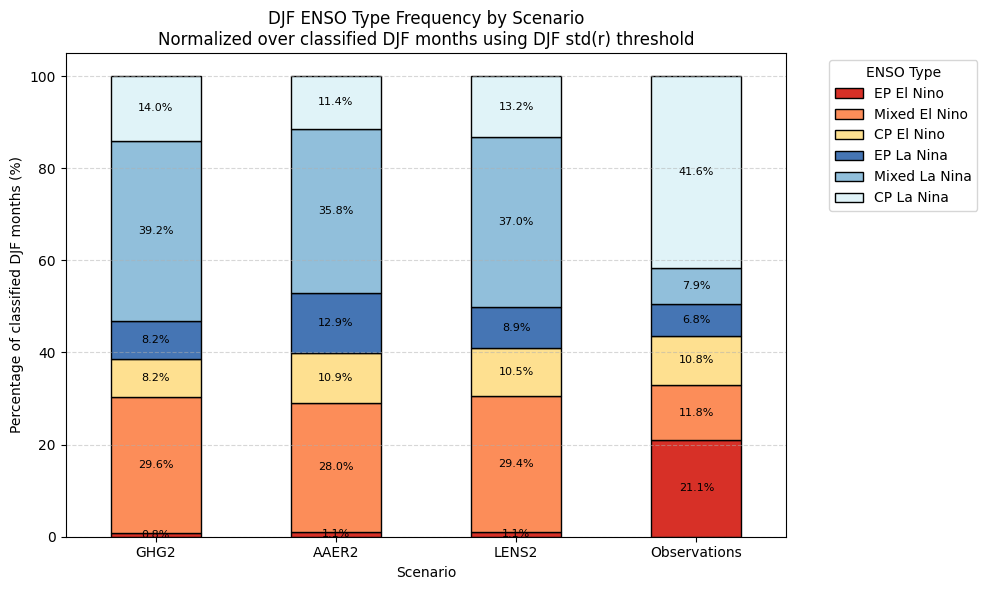

In [34]:
# === Normalized DJF ENSO Frequencies (% of classified DJF months) ===
def filter_djf(df):
    df = df.copy()
    df['Month'] = df['Date'].dt.month
    df['Season'] = pd.cut(df['Month'] % 12 + 1,
                          bins=[0, 3, 6, 9, 12],
                          labels=['DJF', 'MAM', 'JJA', 'SON'],
                          ordered=False)
    return df[df['Season'] == 'DJF']

def average_djf_frequencies_normalized(member_dict, enso_types):
    freq_tables = []
    for df in member_dict.values():
        df_djf = filter_djf(df)
        df_valid = df_djf[df_djf['ENSO_Type_Model'] != 'None']
        freq = df_valid['ENSO_Type_Model'].value_counts(normalize=True).reindex(enso_types, fill_value=0)
        freq_tables.append(freq)
    freq_df = pd.DataFrame(freq_tables)
    return freq_df.mean().mul(100).round(2)

enso_types = ['EP El Nino', 'Mixed El Nino', 'CP El Nino',
              'EP La Nina', 'Mixed La Nina', 'CP La Nina']

enso_by_scenario_djf_norm = {
    'GHG2': average_djf_frequencies_normalized(ghg_members_normalized, enso_types),
    'AAER2': average_djf_frequencies_normalized(aaer_members_normalized, enso_types),
    'LENS2': average_djf_frequencies_normalized(lens_members_normalized, enso_types),
    'Observations': filter_djf(data_obs_aligned)
        .loc[lambda df: df['ENSO_Type_Model'] != 'None', 'ENSO_Type_Model']
        .value_counts(normalize=True).reindex(enso_types, fill_value=0).mul(100).round(2)
}

enso_df_djf_norm = pd.DataFrame(enso_by_scenario_djf_norm)

print("DJF ENSO Type Frequency by Scenario (Normalized)\n"
      "Normalized over classified DJF months using DJF std(r) threshold.\n"
      "Values represent the percentage of classified DJF months assigned to each ENSO type.\n")

display(enso_df_djf_norm)

# --- Plotting ---
fig, ax = plt.subplots(figsize=(10, 6))
enso_df_djf_norm.T.plot(
    kind='bar',
    stacked=True,
    color=[enso_colors[col] for col in enso_df_djf_norm.index],
    edgecolor='black',
    ax=ax
)

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f"{height:.1f}%",
                ha='center',
                va='center',
                fontsize=8,
                color='black'
            )

ax.set_title('DJF ENSO Type Frequency by Scenario\nNormalized over classified DJF months using DJF std(r) threshold')
ax.set_ylabel('Percentage of classified DJF months (%)')
ax.set_xlabel('Scenario')
ax.set_xticks(range(len(enso_df_djf_norm.columns)))
ax.set_xticklabels(enso_df_djf_norm.columns, rotation=0)
ax.legend(title='ENSO Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# --- Saving figure to directory ---
plt.savefig("block18_djf_enso_frequencies_normalized.png", dpi=300)

plt.show()

# Unnormalized DJF ENSO Frequency Analysis
Computes ENSO type frequencies during DJF months as a percentage of all DJF months, without normalizing over classified events. Results are presented in both tabular and stacked bar chart form, comparing scenarios against observations.

DJF ENSO Type Frequency by Scenario (Unnormalized)
Percent of all DJF months using DJF std(r) threshold.
Values represent the percentage of all DJF months assigned to each ENSO type.



,GHG2,AAER2,LENS2,Observations
ENSO_Type_Model,,,,
EP El Nino,0.48,0.71,0.76,16.53
Mixed El Nino,18.95,18.46,20.19,9.30
CP El Nino,5.23,7.17,7.23,8.47
EP La Nina,5.29,8.54,6.12,5.37
Mixed La Nina,25.05,23.58,25.46,6.20
CP La Nina,8.97,7.56,9.09,32.64


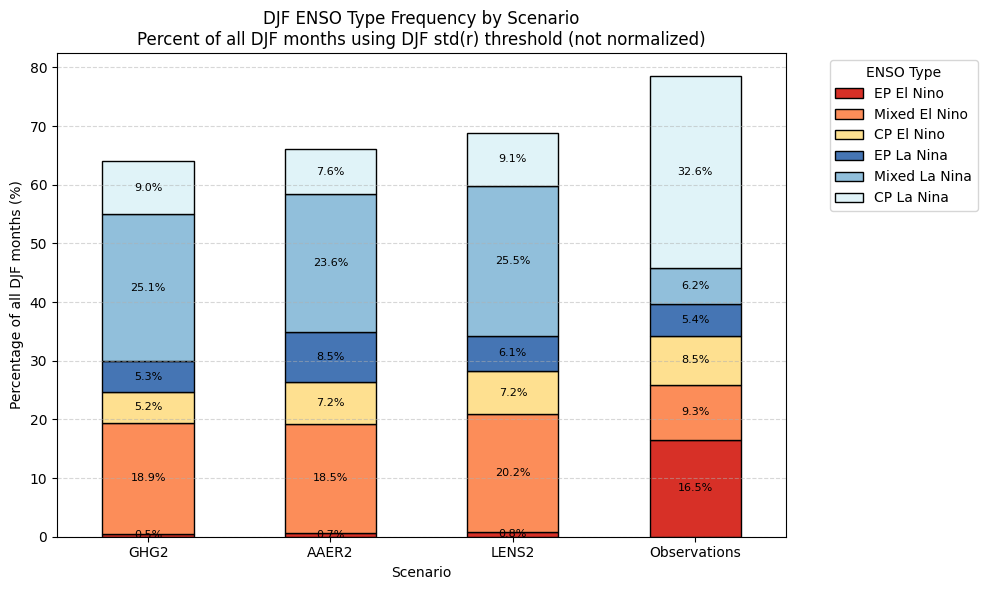

In [35]:
# === Unnormalized DJF ENSO Frequencies (% of all DJF months) ===
def average_djf_frequencies_unnormalized(member_dict, enso_types):
    freq_tables = []
    for df in member_dict.values():
        df_djf = filter_djf(df)
        total_months = len(df_djf)
        freq = df_djf['ENSO_Type_Model'].value_counts().reindex(enso_types, fill_value=0)
        freq = freq.div(total_months).mul(100).round(2)
        freq_tables.append(freq)
    freq_df = pd.DataFrame(freq_tables)
    return freq_df.mean().round(2)

enso_by_scenario_djf_abs = {
    'GHG2': average_djf_frequencies_unnormalized(ghg_members_normalized, enso_types),
    'AAER2': average_djf_frequencies_unnormalized(aaer_members_normalized, enso_types),
    'LENS2': average_djf_frequencies_unnormalized(lens_members_normalized, enso_types),
    'Observations': filter_djf(data_obs_aligned)['ENSO_Type_Model']
        .value_counts().reindex(enso_types, fill_value=0)
        .div(len(filter_djf(data_obs_aligned))).mul(100).round(2)
}

enso_df_djf_abs = pd.DataFrame(enso_by_scenario_djf_abs)

print("DJF ENSO Type Frequency by Scenario (Unnormalized)\n"
      "Percent of all DJF months using DJF std(r) threshold.\n"
      "Values represent the percentage of all DJF months assigned to each ENSO type.\n")

display(enso_df_djf_abs)

# --- Plotting ---
fig, ax = plt.subplots(figsize=(10, 6))
enso_df_djf_abs.T.plot(
    kind='bar',
    stacked=True,
    color=[enso_colors[col] for col in enso_df_djf_abs.index],
    edgecolor='black',
    ax=ax
)

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f"{height:.1f}%",
                ha='center',
                va='center',
                fontsize=8,
                color='black'
            )

ax.set_title('DJF ENSO Type Frequency by Scenario\nPercent of all DJF months using DJF std(r) threshold (not normalized)')
ax.set_ylabel('Percentage of all DJF months (%)')
ax.set_xlabel('Scenario')
ax.set_xticks(range(len(enso_df_djf_abs.columns)))
ax.set_xticklabels(enso_df_djf_abs.columns, rotation=0)
ax.legend(title='ENSO Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# --- Saving figure to directory ---
plt.savefig("block19_djf_enso_frequencies_unnormalized.png", dpi=300)

plt.show()

# Threshold Sensitivity and Adaptive ENSO Classification
Implements a fixed-threshold ENSO classifier and evaluates divergence between observations and LENS2 across multiple r-thresholds. Plots KL and Jensen–Shannon metrics, visualizes r-distribution by ENSO type with DJF std overlay, and applies an adaptive threshold (top 60% r) to compare scenario frequencies.

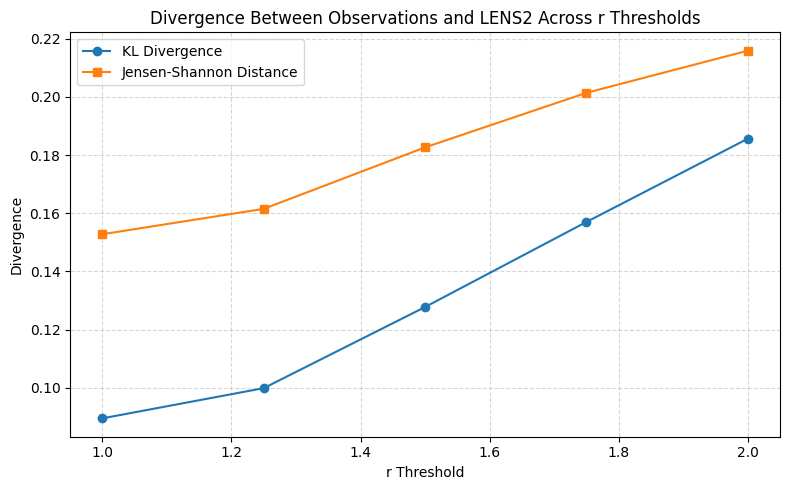

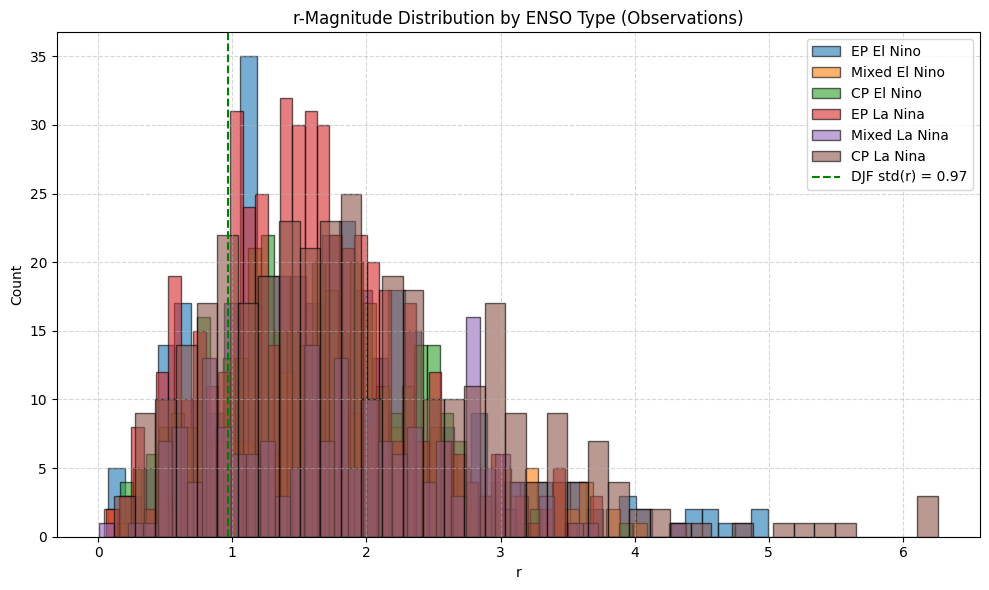

Adaptive threshold (top 60% r): 1.44
KL Divergence (adaptive): 0.123, JS Distance (adaptive): 0.179


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy

# --- Fixed-threshold ENSO classifier ---
def classify_enso_model_fixed(data, r_threshold):
    r, theta = calculate_ucei_model(data)
    theta_deg = (np.degrees(theta) + 360) % 360

    data = data.copy()
    data['r'] = r
    data['theta'] = theta
    data['theta_deg'] = theta_deg
    data['ENSO_Type_Model'] = 'None'

    mask = r >= r_threshold
    data.loc[mask, 'ENSO_Type_Model'] = np.select(
        [
            (theta_deg[mask] > 15) & (theta_deg[mask] < 90),
            (theta_deg[mask] > 345) | (theta_deg[mask] < 15),
            (theta_deg[mask] > 270) & (theta_deg[mask] < 345),
            (theta_deg[mask] > 195) & (theta_deg[mask] < 270),
            (theta_deg[mask] > 165) & (theta_deg[mask] < 195),
            (theta_deg[mask] > 90) & (theta_deg[mask] < 165)
        ],
        ['EP El Nino', 'Mixed El Nino', 'CP El Nino',
         'EP La Nina', 'Mixed La Nina', 'CP La Nina'],
        default='None'
    )

    return data

# --- Helper Functions ---
def classify_and_count(df, r_threshold, enso_types):
    classified = classify_enso_model_fixed(df.copy(), r_threshold=r_threshold)
    classified = classified[classified['ENSO_Type_Model'] != 'None']
    return classified['ENSO_Type_Model'].value_counts(normalize=True).reindex(enso_types, fill_value=0)

def average_member_counts(member_dict, r_threshold, enso_types):
    freqs = []
    for df in member_dict.values():
        classified = classify_enso_model_fixed(df.copy(), r_threshold=r_threshold)
        classified = classified[classified['ENSO_Type_Model'] != 'None']
        freq = classified['ENSO_Type_Model'].value_counts(normalize=True).reindex(enso_types, fill_value=0)
        freqs.append(freq)
    return pd.DataFrame(freqs).mean()

def compute_divergence(obs_freq, model_freq):
    kl = entropy(obs_freq + 1e-10, model_freq + 1e-10)
    js = jensenshannon(obs_freq, model_freq)
    return kl, js

# --- Threshold Sweep ---
thresholds = [1.0, 1.25, 1.5, 1.75, 2.0]
divergence_results = []

for t in thresholds:
    obs_freq = classify_and_count(data_obs_aligned, t, enso_types)
    lens_freq = average_member_counts(lens_members_normalized, t, enso_types)
    kl, js = compute_divergence(obs_freq.values, lens_freq.values)
    divergence_results.append({'Threshold': t, 'KL': kl, 'JS': js})

div_df = pd.DataFrame(divergence_results)

# --- Plotting Divergence Metrics ---
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(div_df['Threshold'], div_df['KL'], label='KL Divergence', marker='o')
ax.plot(div_df['Threshold'], div_df['JS'], label='Jensen-Shannon Distance', marker='s')
ax.set_title('Divergence Between Observations and LENS2 Across r Thresholds')
ax.set_xlabel('r Threshold')
ax.set_ylabel('Divergence')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# --- Saving divergence metrics figure ---
plt.savefig("block20_divergence_threshold_sweep.png", dpi=300)

plt.show()

# --- r-distribution by ENSO type (Observations) ---
classified_obs = classify_enso_model_fixed(data_obs_aligned.copy(), r_threshold=0)
classified_obs = classified_obs[classified_obs['ENSO_Type_Model'] != 'None']

plt.figure(figsize=(10, 6))
for etype in enso_types:
    subset = classified_obs[classified_obs['ENSO_Type_Model'] == etype]
    plt.hist(subset['r'], bins=40, alpha=0.6, label=etype, edgecolor='black')

# Overlaying DJF std threshold
r_djf_std = data_obs_aligned[data_obs_aligned['Month'].isin([12, 1, 2])]['r'].std()
plt.axvline(r_djf_std, color='green', linestyle='--', label=f'DJF std(r) = {r_djf_std:.2f}')

plt.title('r-Magnitude Distribution by ENSO Type (Observations)')
plt.xlabel('r')
plt.ylabel('Count')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# --- Saving r-distribution figure ---
plt.savefig("block20_r_distribution_observations.png", dpi=300)

plt.show()

# --- Adaptive Thresholding (Top 60% r) ---
r_values = classified_obs['r'].sort_values()
adaptive_threshold = r_values.quantile(0.4)  # keep top 60%
print(f"Adaptive threshold (top 60% r): {adaptive_threshold:.2f}")

obs_freq_adapt = classify_and_count(data_obs_aligned, adaptive_threshold, enso_types)
lens_freq_adapt = average_member_counts(lens_members_normalized, adaptive_threshold, enso_types)
kl_adapt, js_adapt = compute_divergence(obs_freq_adapt.values, lens_freq_adapt.values)
print(f"KL Divergence (adaptive): {kl_adapt:.3f}, JS Distance (adaptive): {js_adapt:.3f}")

# ENSO Composite Analysis Across Observations and Model Ensembles
This script processes observational and model SST datasets (OBS, LENS2, GHG2, AAER2) to compute ENSO-related composites across several historical windows. It loads and standardizes SST fields (handling both rectilinear and POP curvilinear grids), extracts Niño-3 and Niño-4 monthly anomalies, converts them into DJF seasonal indices, and classifies each season as El Niño, La Niña, or Neutral using an 
𝑟
r–
𝜃
θ metric with a percentile-based event threshold. For each dataset and time window, it constructs composite DJF SST anomalies by averaging event years relative to a climatology. The script dentifies ENSO events using a configurable top-fraction threshold (60%), meaning only seasons above the 40th percentile of r are classified. Because LENS uses a POP grid, the script regrids all model composites to the observational 1°×1° grid using xESMF when available or scipy.griddata otherwise. It then computes ensemble-mean composites for each experiment and produces regridded, analysis-ready datasets for plotting.

In [27]:
# Full merged script: POP -> lat/lon regridding + composites + plotting

import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from collections import defaultdict
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata

# -------------------------
# USER CONFIG
# -------------------------
base_path = r'C:\Users\nickr\Desktop\Indexes Capstone\\'   
out_dir = os.path.join(base_path, 'composites_output')
os.makedirs(out_dir, exist_ok=True)

windows = [(1854, 1900), (1901, 1950), (1951, 2000), (2001, 2015)]
top_fraction = 0.60
pct_for_threshold = 100.0 * (1.0 - top_fraction)
preferred_clim = (1971, 2000)
fallback_clim = (1981, 2010)

plot_extent = [120, 300, -30, 30]     
levels = np.arange(-2.0, 2.05, 0.25)
cmap = 'RdBu_r'
contour_levels = [-2.0, -1.5, -1.0, -0.5, 0.5, 1.0, 1.5, 2.0]

# -------------------------
# Dependency: try xesmf, fallback to griddata if missing
# -------------------------
USE_XESMF = False
try:
    import xesmf as xe
    USE_XESMF = True
    print("xESMF available: will use xESMF for POP->latlon regridding (recommended).")
except Exception:
    print("xESMF not available: will fall back to scipy.griddata for regridding (slower).")
    USE_XESMF = False

# -------------------------
# HELPERS (time, lon wrapping, reading)
# -------------------------
def safe_convert_time_to_timestamps(time_values):
    out = []
    for t in np.asarray(time_values):
        try:
            out.append(pd.to_datetime(t))
        except Exception:
            try:
                out.append(pd.to_datetime(str(t)))
            except Exception:
                out.append(pd.NaT)
    return pd.DatetimeIndex(out)

def wrap_lon_to_360_da(da):
    """Wrap 1D lon to 0-360 if necessary (returns dataarray)."""
    if 'lon' not in da.coords:
        return da
    lon = da['lon']
    if lon.ndim == 1 and lon.min() < 0:
        newlon = (lon + 360) % 360
        da = da.assign_coords(lon=newlon).sortby('lon')
    return da

def extract_djf_times(da, season_year):
    dec, jan, feb = f"{season_year-1}-12", f"{season_year}-01", f"{season_year}-02"
    try:
        tstr = da.time.dt.strftime("%Y-%m").values
    except Exception:
        tstr = np.array([pd.Timestamp(t).strftime("%Y-%m") for t in da.time.values])
    mask = np.isin(tstr, [dec, jan, feb])
    return da.time.values[mask]

def compute_djf_climatology_yearly_mean(sst_da, years_subset):
    seasons = []
    for y in years_subset:
        times = extract_djf_times(sst_da, y)
        if len(times):
            seasons.append(sst_da.sel(time=times).mean("time", skipna=True))
    if not seasons:
        return None
    return xr.concat(seasons, "season").mean("season", skipna=True)

# -------------------------
# Coordinate helpers (handles 1D rectilinear and 2D POP)
# -------------------------
def standardize_coords(ds, varname):
    """Return DataArray with lat/lon coords attached (works for TLAT/TLONG or 1D lat/lon)."""
    da = ds[varname]
    # POP style: TLAT / TLONG (2D)
    if 'TLAT' in ds.variables and 'TLONG' in ds.variables:
        da = da.assign_coords(lat=ds['TLAT'], lon=ds['TLONG'])
        return da
    # Typical rectilinear grid: lat/lon either in coords or variables
    if ('lat' in da.coords and 'lon' in da.coords):
        return da
    if 'lat' in ds.variables and 'lon' in ds.variables:
        return da.assign_coords(lat=ds['lat'], lon=ds['lon'])
    raise KeyError("No usable lat/lon coordinates found in dataset.")

def is_pop_grid(da):
    """Return True if the DataArray has 2D lat or lon (POP-like grid)."""
    lat = da.coords.get('lat', None)
    lon = da.coords.get('lon', None)
    if lat is None or lon is None:
        return False
    return (getattr(lat, 'ndim', 1) == 2) or (getattr(lon, 'ndim', 1) == 2)
# -------------------------
# Nino region extraction + seasonal table builder
# -------------------------
def get_nino3_nino4_from_sst_da(sst_da):
    da = sst_da
    # If 1D lat/lon (rectilinear)
    if ('lat' in da.coords and da['lat'].ndim == 1) and ('lon' in da.coords and da['lon'].ndim == 1):
        da = wrap_lon_to_360_da(da)
        # ensuring ascending lat
        if da['lat'][0] > da['lat'][-1]:
            da = da.sortby('lat')
        n3 = da.sel(lat=slice(-5, 5), lon=slice(210, 270)).mean(dim=('lat', 'lon'))
        n4 = da.sel(lat=slice(-5, 5), lon=slice(160, 210)).mean(dim=('lat', 'lon'))
        return n3, n4
    # If 2D curvilinear (POP)
    lat = da.coords['lat']
    lon = da.coords['lon']
    if lat.ndim == 2 and lon.ndim == 2:
        # building boolean masks on the curvilinear grid
        lat_mask = (lat >= -5) & (lat <= 5)
        lon360 = (lon + 360) % 360
        n3_mask = lat_mask & (lon360 >= 210) & (lon360 <= 270)
        n4_mask = lat_mask & (lon360 >= 160) & (lon360 <= 210)
        # averaging over spatial dims (whatever they are)
        spatial_dims = [d for d in da.dims if d not in ['time']]
        n3 = da.where(n3_mask).mean(dim=spatial_dims, skipna=True)
        n4 = da.where(n4_mask).mean(dim=spatial_dims, skipna=True)
        return n3, n4
    raise ValueError("Unsupported coordinate structure for Nino extraction.")

def build_seasons_table_from_ds(ds, sst_var, clim_period=preferred_clim):
    sst = standardize_coords(ds, sst_var)
    # if there is a depth/lev dim, drop first index
    for z in ['z_t','lev','depth','z','ZT']:
        if z in sst.dims:
            sst = sst.isel({z:0})
            break
    times = safe_convert_time_to_timestamps(sst.time.values)
    # choose climatology
    if (preferred_clim[0] >= times.year.min()) and (preferred_clim[1] <= times.year.max()):
        clim_ys, clim_ye = preferred_clim
    elif (fallback_clim[0] >= times.year.min()) and (fallback_clim[1] <= times.year.max()):
        clim_ys, clim_ye = fallback_clim
    else:
        clim_ys, clim_ye = int(times.year.min()), int(times.year.min()) + 29
    n3_da, n4_da = get_nino3_nino4_from_sst_da(sst)
    n3 = pd.Series(np.asarray(n3_da), index=times)
    n4 = pd.Series(np.asarray(n4_da), index=times)
    mask_clim = (n3.index.year >= clim_ys) & (n3.index.year <= clim_ye)
    clim3 = n3[mask_clim].groupby(n3[mask_clim].index.month).mean()
    clim4 = n4[mask_clim].groupby(n4[mask_clim].index.month).mean()
    n3_anom = pd.Series(index=n3.index, data=(n3.values - np.array([clim3[m] for m in n3.index.month])))
    n4_anom = pd.Series(index=n4.index, data=(n4.values - np.array([clim4[m] for m in n4.index.month])))
    monthly = pd.DataFrame({
        'Date': n3.index,
        'Month': n3.index.month,
        'Year': n3.index.year,
        'N3_anom': n3_anom.values,
        'N4_anom': n4_anom.values
    })
    monthly['Season_Year'] = monthly['Year']
    monthly.loc[monthly['Month'] == 12, 'Season_Year'] = monthly.loc[monthly['Month'] == 12, 'Year'] + 1
    djf = monthly[monthly['Month'].isin([12, 1, 2])].copy()
    seasonal = djf.groupby('Season_Year')[['N3_anom', 'N4_anom']].mean()
    seasonal = seasonal.rename(columns={'N3_anom':'N3_DJF','N4_anom':'N4_DJF'}).reset_index()
    return seasonal, sst

# -------------------------
# ENSO classification (r/theta) and seasons -> composites
# -------------------------
def compute_r_theta_and_classify(seasonal_df, threshold_pct=pct_for_threshold):
    df = seasonal_df.copy()
    df['r'] = np.sqrt(df['N3_DJF']**2 + df['N4_DJF']**2)
    df['theta'] = np.degrees(np.arctan2(df['N4_DJF'], df['N3_DJF'])) % 360
    if df['r'].dropna().empty:
        r_thresh = np.nan
    else:
        r_thresh = np.nanpercentile(df['r'], threshold_pct)
    df['is_event'] = df['r'] >= r_thresh
    df['Phase'] = 'Neutral'
    df.loc[df['is_event'] & (df['theta'] < 180), 'Phase'] = 'El Nino'
    df.loc[df['is_event'] & (df['theta'] >= 180), 'Phase'] = 'La Nina'
    return df, r_thresh

def seasons_to_composite(sst_da, season_list, start, end):
    seas = []
    for y in season_list:
        if start <= y <= end:
            times = extract_djf_times(sst_da, y)
            if len(times):
                seas.append(sst_da.sel(time=times).mean(dim='time', skipna=True))
    if not seas:
        return None
    comp = xr.concat(seas, dim='season').mean(dim='season', skipna=True)
    clim = compute_djf_climatology_yearly_mean(sst_da, range(start, end+1))
    if clim is None:
        return None
    return comp - clim

# -------------------------
# Regridding helpers
# -------------------------
def build_pop_to_latlon_regridder_from_ds(pop_ds, target_lat=None, target_lon=None):
    """
    Build xESMF regridder given a POP-style dataset or DataArray (with TLAT/TLONG or lat/lon 2D).
    """
    if not USE_XESMF:
        return None
    # building target 1x1 grid by default (lon in 0.5..359.5 to match obs 0..360 ordering)
    if target_lat is None:
        target_lat = np.arange(-89.5, 90.5, 1.0)
    if target_lon is None:
        target_lon = np.arange(0.5, 360.5, 1.0)
    ds_out = xr.Dataset({'lat': (['lat'], target_lat), 'lon': (['lon'], target_lon)})

    # Building source dataset for xESMF. Try to find 2D lat/lon coords
    # Accepting either TLAT/TLONG or lat/lon 2D coords already present
    if 'TLAT' in pop_ds.coords and 'TLONG' in pop_ds.coords:
        ds_in = xr.Dataset({
            'lat': (('y','x'), pop_ds['TLAT'].values),
            'lon': (('y','x'), pop_ds['TLONG'].values),
            # adding dummy sst variable on same grid (dims y,x) to define grid
            'sst': (('y','x'), np.zeros_like(pop_ds['TLAT'].values))
        })
    elif ('lat' in pop_ds.coords and pop_ds['lat'].ndim == 2) and ('lon' in pop_ds.coords and pop_ds['lon'].ndim == 2):
        ds_in = xr.Dataset({
            'lat': (('y','x'), pop_ds['lat'].values),
            'lon': (('y','x'), pop_ds['lon'].values),
            'sst': (('y','x'), np.zeros_like(pop_ds['lat'].values))
        })
    else:
        raise RuntimeError("Cannot find 2D lat/lon in provided POP dataset to build regridder.")

    # Creating regridder (bilinear)
    regridder = xe.Regridder(ds_in, ds_out, 'bilinear', periodic=True, reuse_weights=False)
    return regridder

def griddata_regrid_pop_to_ll(comp, target_lat, target_lon, fill_nearest=True):
    """
    Fallback regridding using scipy.griddata for POP grid DataArray comp.
    Assumes comp has coords TLAT/TLONG or lat/lon 2D on the same dims.
    target_lat/target_lon are 1D arrays representing obs grid.
    """
    # identifying 2D coords
    if 'TLAT' in comp.coords and 'TLONG' in comp.coords:
        TLAT = comp['TLAT'].values
        TLONG = comp['TLONG'].values
    elif ('lat' in comp.coords and comp['lat'].ndim == 2) and ('lon' in comp.coords and comp['lon'].ndim == 2):
        TLAT = comp['lat'].values
        TLONG = comp['lon'].values
    else:
        raise RuntimeError("POP-style 2D coords not found for griddata regridding.")

    vals = comp.values
    mask = np.isfinite(vals) & np.isfinite(TLAT) & np.isfinite(TLONG)
    src_points = np.column_stack([TLAT[mask].ravel(), TLONG[mask].ravel()])
    src_values = vals[mask].ravel()
    tgt_lon2d, tgt_lat2d = np.meshgrid(target_lon, target_lat)

    interp_linear = griddata(src_points, src_values, (tgt_lat2d, tgt_lon2d), method='linear')
    if fill_nearest:
        interp_nearest = griddata(src_points, src_values, (tgt_lat2d, tgt_lon2d), method='nearest')
        out_vals = np.where(np.isfinite(interp_linear), interp_linear, interp_nearest)
    else:
        out_vals = interp_linear

    out = xr.DataArray(out_vals, coords={'lat': target_lat, 'lon': target_lon}, dims=('lat','lon'), name=comp.name)
    return out

def regrid_lens_mean_dict(lens_mean_dict, target_lat, target_lon, pop_regridder=None):
    """Regrid all LENS composites (dict[(start,end)]->{'El':da,'La':da}) to target grid."""
    regridded = {}
    for (start,end), phases in lens_mean_dict.items():
        regridded[(start,end)] = {}
        for phase, comp in phases.items():
            if comp is None:
                regridded[(start,end)][phase] = None
                continue
            # if comp already on rectilinear 1D grid, ensuring lon sorted and assign
            if not is_pop_grid(comp):
                # ensuring lon is 0..360 and sorted
                if 'lon' in comp.coords and comp['lon'].ndim == 1 and comp['lon'].max() > 180:
                    lons = ((comp['lon'].values + 180) % 360) - 180
                    comp2 = comp.assign_coords(lon=lons).sortby('lon')
                else:
                    comp2 = comp
                # if dims are lat,lon already matching target, just reindex (or interp)
                if np.allclose(comp2['lat'].values, target_lat) and np.allclose(comp2['lon'].values, target_lon):
                    regridded[(start,end)][phase] = comp2
                else:
                    # simple interp using xarray (works when both are rectilinear)
                    try:
                        regr = comp2.interp(lat=target_lat, lon=target_lon, method='linear')
                        regridded[(start,end)][phase] = regr
                    except Exception:
                        regridded[(start,end)][phase] = comp2  
                continue

            # comp is POP (2D coords)
            if USE_XESMF and (pop_regridder is not None):
                try:
                    # renaming TLAT/TLONG to lat/lon dims expected by xesmf regridder built earlier
                    renamed = comp.rename({'lat':'TLAT','lon':'TLONG'}) if ('lat' in comp.coords and comp['lat'].ndim==2) else comp
                    ds_in = renamed.to_dataset(name='sst')
                    ds_out = pop_regridder(ds_in)
                    regr = ds_out['sst']
                    regridded[(start,end)][phase] = regr
                    continue
                except Exception as e:
                    print("xESMF regrid failed for one composite, falling back to griddata:", e)

            # fallback: griddata interpolation
            try:
                rg = griddata_regrid_pop_to_ll(comp, target_lat, target_lon, fill_nearest=True)
                regridded[(start,end)][phase] = rg
            except Exception as e:
                print("griddata fallback failed for composite:", e)
                regridded[(start,end)][phase] = None
    return regridded

# -------------------------
# FILE DISCOVERY
# -------------------------
def discover_files(base_path, keyword):
    return sorted(glob.glob(os.path.join(base_path, f"*{keyword}*.nc")))

obs_file = os.path.join(base_path, 'sst.mnmean.nc')
lens_files = discover_files(base_path, "LE2")
ghg_files  = discover_files(base_path, "CESM2-SF-GHG")
aaer_files = discover_files(base_path, "CESM2-SF-AAER")

print("Files found: OBS:", os.path.exists(obs_file),
      "| LENS2:", len(lens_files), " | GHG2:", len(ghg_files), " | AAER2:", len(aaer_files))
# -------------------------
# Build observational seasons table
# -------------------------
if not os.path.exists(obs_file):
    raise FileNotFoundError(f"Observational file not found at {obs_file}")

ds_obs = xr.open_dataset(obs_file, decode_times=True)
sst_var_obs = next((v for v in ["sst","SST","tos","TS","SST_cpl"] if v in ds_obs.variables), None)
if sst_var_obs is None:
    raise KeyError("No SST variable in observational file.")
seasonal_full_obs, sst_da_obs = build_seasons_table_from_ds(ds_obs, sst_var_obs)
# -------------------------
# Process ensembles (LENS needs grouping by member)
# -------------------------
def group_lens_member_files(lens_files):
    groups = defaultdict(list)
    for f in lens_files:
        parts = os.path.basename(f).split(".")
        # heuristic: looking for 'LE2' dot-splitted naming, member id might be parts[2] or parts[1]
        if len(parts) >= 3:
            member_id = parts[2]
        else:
            member_id = os.path.basename(f)
        groups[member_id].append(f)
    for k in groups:
        groups[k] = sorted(groups[k])
    return groups

def open_lens_member(files):
    ds = xr.open_mfdataset(files, combine='by_coords', decode_times=True)
    sst_var = next((v for v in ["sst","SST","tos","TS","SST_cpl"] if v in ds.variables), None)
    if sst_var is None:
        raise KeyError(f"No SST variable found in LENS member files: {files[0]}")
    seasonal, sst_da = build_seasons_table_from_ds(ds, sst_var)
    return seasonal, sst_da, ds

def process_ensemble_files_continuous(file_list, is_lens=False):
    member_tables = {}
    member_composites = {}

    if is_lens:
        groups = group_lens_member_files(file_list)
        iterable = list(groups.items())
    else:
        iterable = [(f"member_{i:03d}", [fp]) for i, fp in enumerate(file_list, start=1)]

    for member_id, files in iterable:
        try:
            print(f"Processing member {member_id} ({len(files)} files)")
            if is_lens:
                seasonal_full, sst_da, ds_member = open_lens_member(files)
            else:
                ds_member = xr.open_dataset(files[0], decode_times=True)
                sst_var = next((v for v in ["sst","SST","tos","TS","SST_cpl"] if v in ds_member.variables), None)
                if sst_var is None:
                    raise KeyError(f"No SST variable found in {files[0]}")
                seasonal_full, sst_da = build_seasons_table_from_ds(ds_member, sst_var)

            tables = {}
            composites = {}
            for (start,end) in windows:
                sw = seasonal_full[(seasonal_full.Season_Year >= start) & (seasonal_full.Season_Year <= end)]
                if sw.empty:
                    tables[(start,end)] = (sw, np.nan)
                    composites[(start,end)] = {'El': None, 'La': None}
                    continue
                dfc, r_thresh = compute_r_theta_and_classify(sw, threshold_pct=pct_for_threshold)
                el_list = dfc[dfc.Phase == "El Nino"].Season_Year.astype(int).tolist()
                la_list = dfc[dfc.Phase == "La Nina"].Season_Year.astype(int).tolist()
                el_comp = seasons_to_composite(sst_da, el_list, start, end) if el_list else None
                la_comp = seasons_to_composite(sst_da, la_list, start, end) if la_list else None
                tables[(start,end)] = (dfc, r_thresh)
                composites[(start,end)] = {'El': el_comp, 'La': la_comp}
            member_tables[member_id] = tables
            member_composites[member_id] = composites
        except Exception as e:
            print(f"Skipping member {member_id} due to error: {e}")
            continue

    return member_tables, member_composites

print("Building OBS composites...")
obs_tables = {}
obs_composites = {}
for (start,end) in windows:
    sw = seasonal_full_obs[(seasonal_full_obs.Season_Year >= start) & (seasonal_full_obs.Season_Year <= end)]
    if sw.empty:
        obs_tables[(start,end)] = (sw, np.nan)
        obs_composites[(start,end)] = {'El': None, 'La': None}
        continue
    dfc, r_thresh = compute_r_theta_and_classify(sw, threshold_pct=pct_for_threshold)
    el_list = dfc[dfc.Phase == "El Nino"].Season_Year.astype(int).tolist()
    la_list = dfc[dfc.Phase == "La Nina"].Season_Year.astype(int).tolist()
    el_comp = seasons_to_composite(sst_da_obs, el_list, start, end) if el_list else None
    la_comp = seasons_to_composite(sst_da_obs, la_list, start, end) if la_list else None
    obs_tables[(start,end)] = (dfc, r_thresh)
    obs_composites[(start,end)] = {'El': el_comp, 'La': la_comp}
print("OBS composites built.")

print("Processing ensemble files (LENS2, GHG2, AAER2)... (this may take a while)")
lens_tables, lens_composites = process_ensemble_files_continuous(lens_files, is_lens=True)
ghg_tables, ghg_composites = process_ensemble_files_continuous(ghg_files, is_lens=False)
aaer_tables, aaer_composites = process_ensemble_files_continuous(aaer_files, is_lens=False)

def compute_ensemble_mean(member_composites, windows):
    out = {}
    for (start,end) in windows:
        out[(start,end)] = {}
        for phase in ['El','La']:
            comps = []
            for m in member_composites.values():
                comp = m[(start,end)][phase]
                if comp is not None:
                    comps.append(comp)
            if comps:
                out[(start,end)][phase] = xr.concat(comps, dim='member').mean('member', skipna=True)
            else:
                out[(start,end)][phase] = None
    return out

lens_mean = compute_ensemble_mean(lens_composites, windows)
ghg_mean  = compute_ensemble_mean(ghg_composites, windows)
aaer_mean = compute_ensemble_mean(aaer_composites, windows)

# -------------------------
# Building regridder (xESMF) from LENS sample if available
# -------------------------
pop_regridder = None
if USE_XESMF and len(lens_files) > 0:
    try:
        # first LENS file, find sst var and the lat/lon 2D coords present
        tmp_ds = xr.open_dataset(lens_files[0], decode_times=True)
        sst_var_tmp = next((v for v in ["sst","SST","tos","TS","SST_cpl"] if v in tmp_ds.variables), None)
        if sst_var_tmp is not None:
            tmp_da = standardize_coords(tmp_ds, sst_var_tmp)
            # preparing a minimal dataset with TLAT/TLONG for regridder creation
            # datasets present TLAT/TLONG as coords on the parent dataset
            pop_regridder = build_pop_to_latlon_regridder_from_ds(tmp_da)
            print("Built xESMF regridder from sample LENS file.")
    except Exception as e:
        print("Failed to build xESMF regridder:", e)
        pop_regridder = None

# -------------------------
# Regridding LENS composites to OBS grid
# -------------------------
# target lat/lon from obs composite (1D)
target_lat = obs_composites[next(iter(obs_composites))]['El'].coords['lat'] if obs_composites[next(iter(obs_composites))]['El'] is not None else sst_da_obs['lat']
target_lon = obs_composites[next(iter(obs_composites))]['El'].coords['lon'] if obs_composites[next(iter(obs_composites))]['El'] is not None else sst_da_obs['lon']

# ensuring numpy arrays
target_lat = np.asarray(target_lat)
target_lon = np.asarray(target_lon)

print("Regridding LENS composites to observational grid...")
lens_mean_regridded = regrid_lens_mean_dict(lens_mean, target_lat, target_lon, pop_regridder)
print("Regridding complete.")

xESMF not available: will fall back to scipy.griddata for regridding (slower).
Files found: OBS: True | LENS2: 204  | GHG2: 60  | AAER2: 80
Building OBS composites...
OBS composites built.
Processing ensemble files (LENS2, GHG2, AAER2)... (this may take a while)
Processing member BHISTcmip6 (204 files)


C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decode_times=True)
C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decode_times=True)
C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decod

C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decode_times=True)
C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decode_times=True)
C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decod

C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decode_times=True)
C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decode_times=True)
C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decod

C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decode_times=True)
C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decode_times=True)
C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decod

C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decode_times=True)
C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decode_times=True)
C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decod

C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decode_times=True)
C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decode_times=True)
C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decod

C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decode_times=True)
C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decode_times=True)
C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decod

C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decode_times=True)
C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decode_times=True)
C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\678529541.py:374: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(files, combine='by_coords', decod

Processing member member_001 (1 files)
Processing member member_002 (1 files)
Processing member member_003 (1 files)
Processing member member_004 (1 files)
Processing member member_005 (1 files)
Processing member member_006 (1 files)
Processing member member_007 (1 files)
Processing member member_008 (1 files)
Processing member member_009 (1 files)
Processing member member_010 (1 files)
Processing member member_011 (1 files)
Processing member member_012 (1 files)
Processing member member_013 (1 files)
Processing member member_014 (1 files)
Processing member member_015 (1 files)
Processing member member_016 (1 files)
Processing member member_017 (1 files)
Processing member member_018 (1 files)
Processing member member_019 (1 files)
Processing member member_020 (1 files)
Processing member member_021 (1 files)
Processing member member_022 (1 files)
Processing member member_023 (1 files)
Processing member member_024 (1 files)
Processing member member_025 (1 files)
Processing member member_

# Multi-window ENSO SST Composites for All Experiments
These plots show El Niño and La Niña SST anomaly composites for each experiment (Observations, LENS2, GHG2, AAER2) across all analysis windows, using each dataset’s mean anomaly fields regridded to a common grid. Each panel displays the spatial pattern of ENSO-phase SST anomalies for a given time window and experiment, allowing direct comparison of how ENSO structure differs across datasets and external forcing conditions.

Ready to plot. keys: ['Observations', 'LENS2', 'GHG2', 'AAER2']
Plotting: Observations


C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\350397039.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


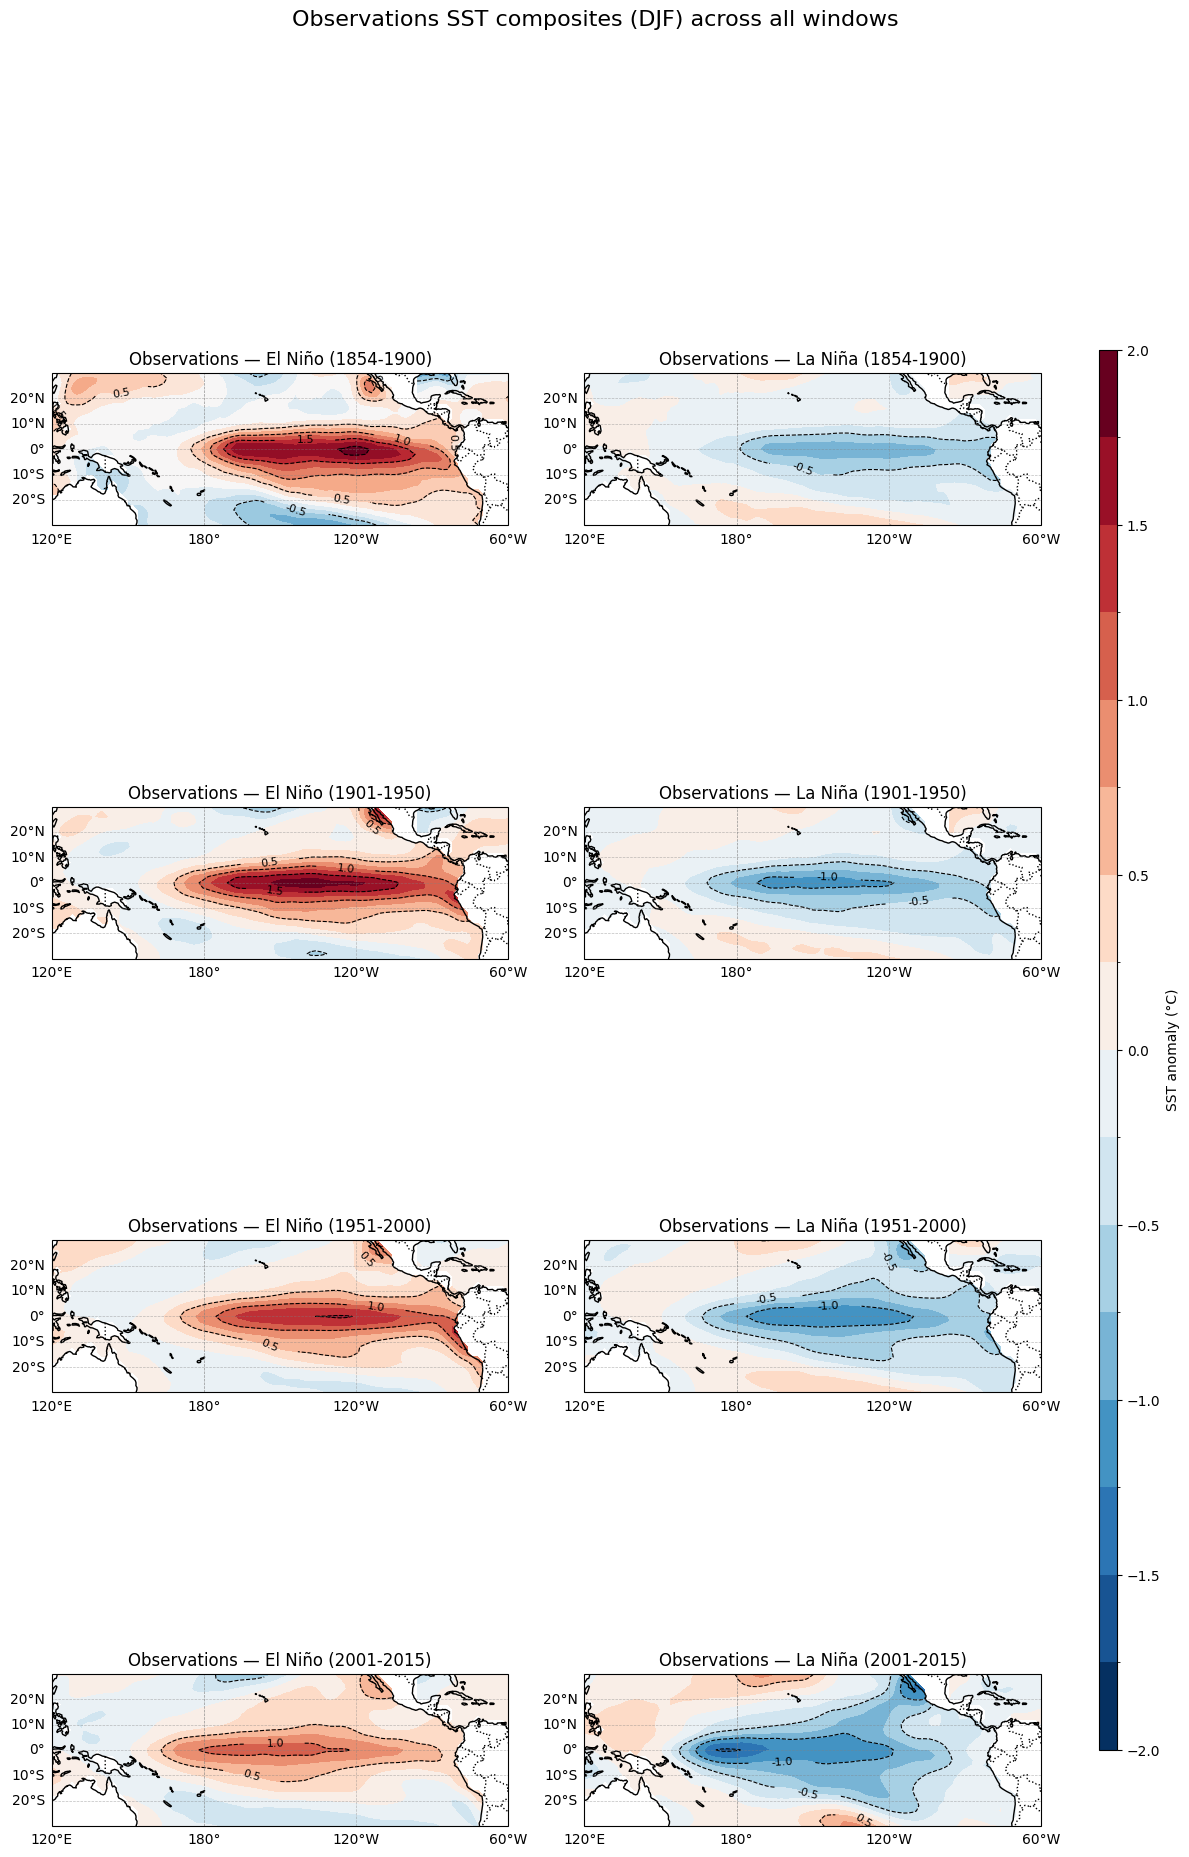

✅ Figure saved to: C:\Users\nickr\Desktop\Indexes Capstone\\composites_output\Observations_composites_all_windows.png
Plotting: LENS2


C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\350397039.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


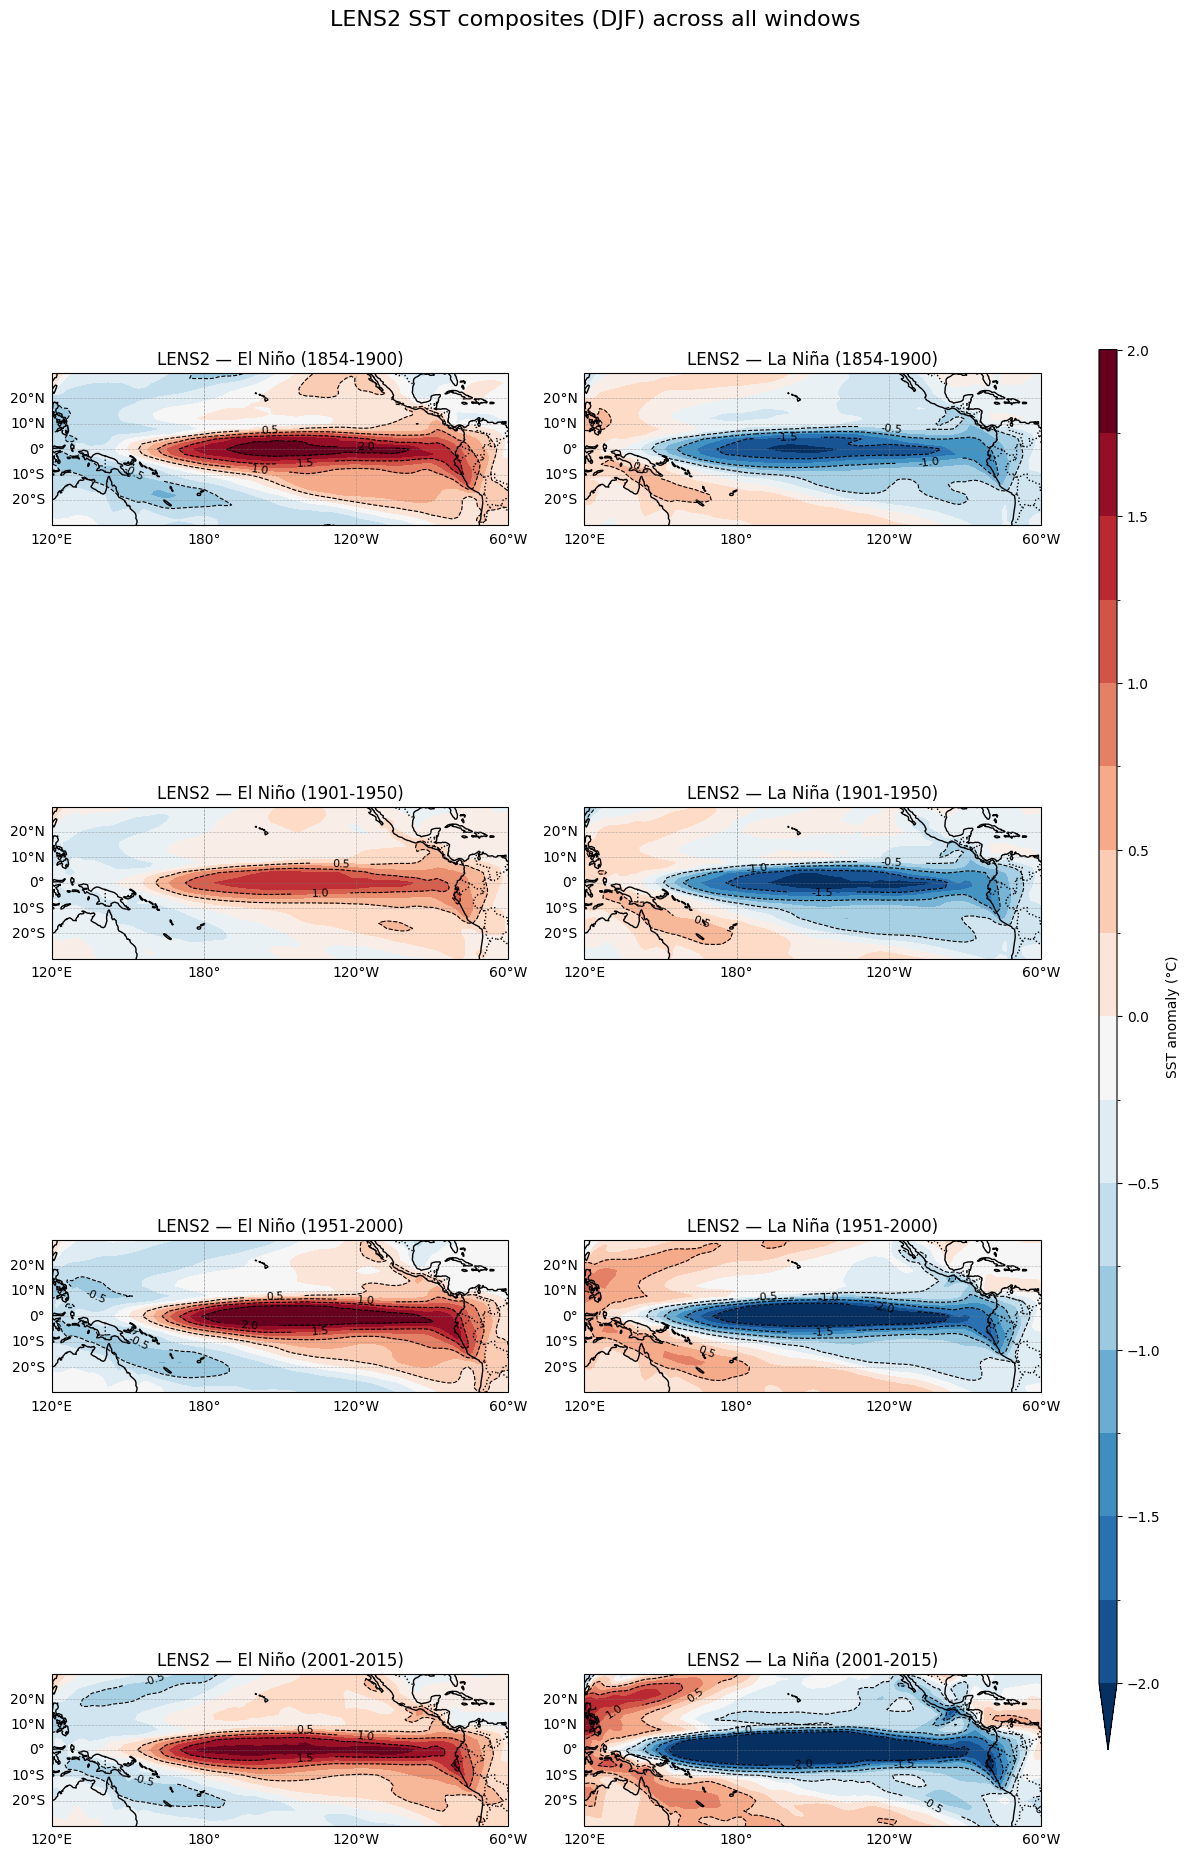

✅ Figure saved to: C:\Users\nickr\Desktop\Indexes Capstone\\composites_output\LENS2_composites_all_windows.png
Plotting: GHG2


C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\350397039.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


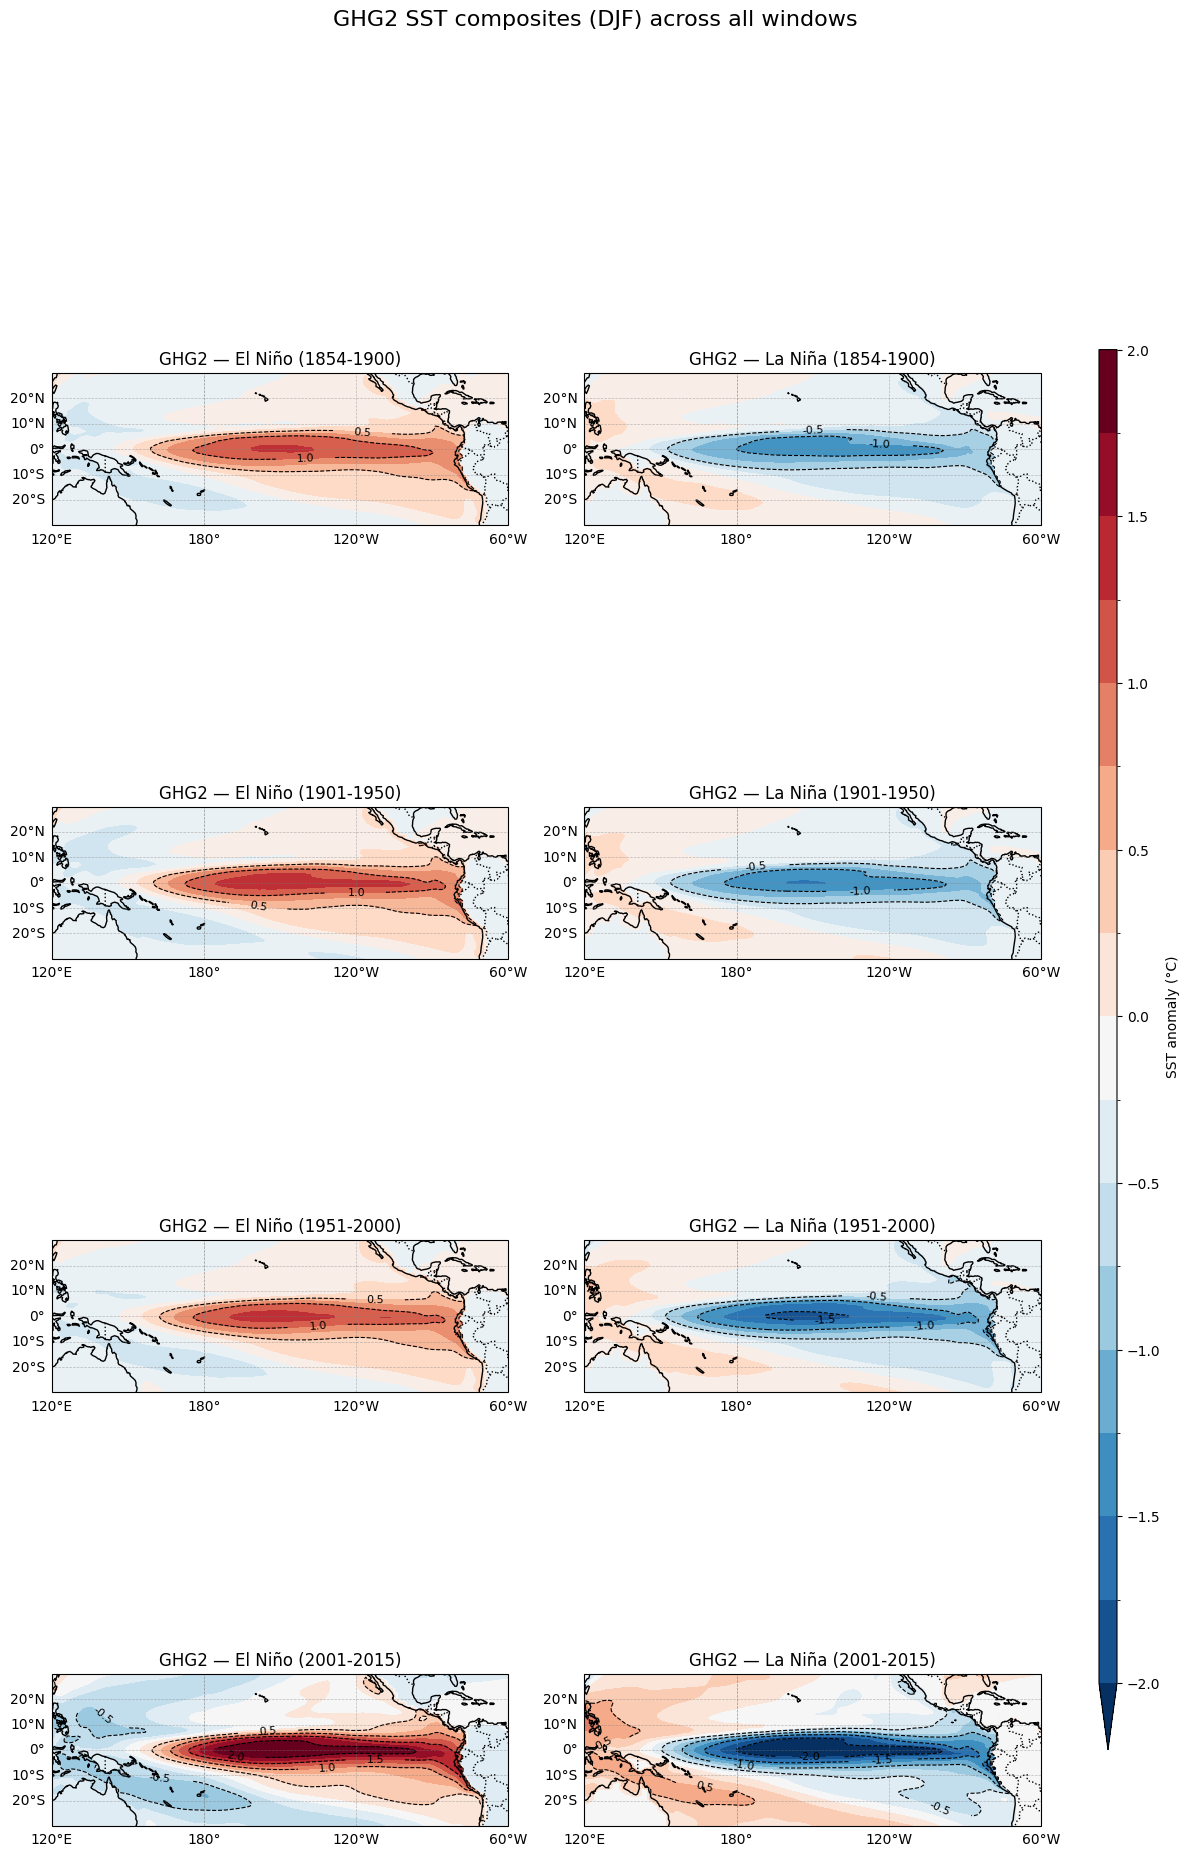

✅ Figure saved to: C:\Users\nickr\Desktop\Indexes Capstone\\composites_output\GHG2_composites_all_windows.png
Plotting: AAER2


C:\Users\nickr\AppData\Local\Temp\ipykernel_30216\350397039.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


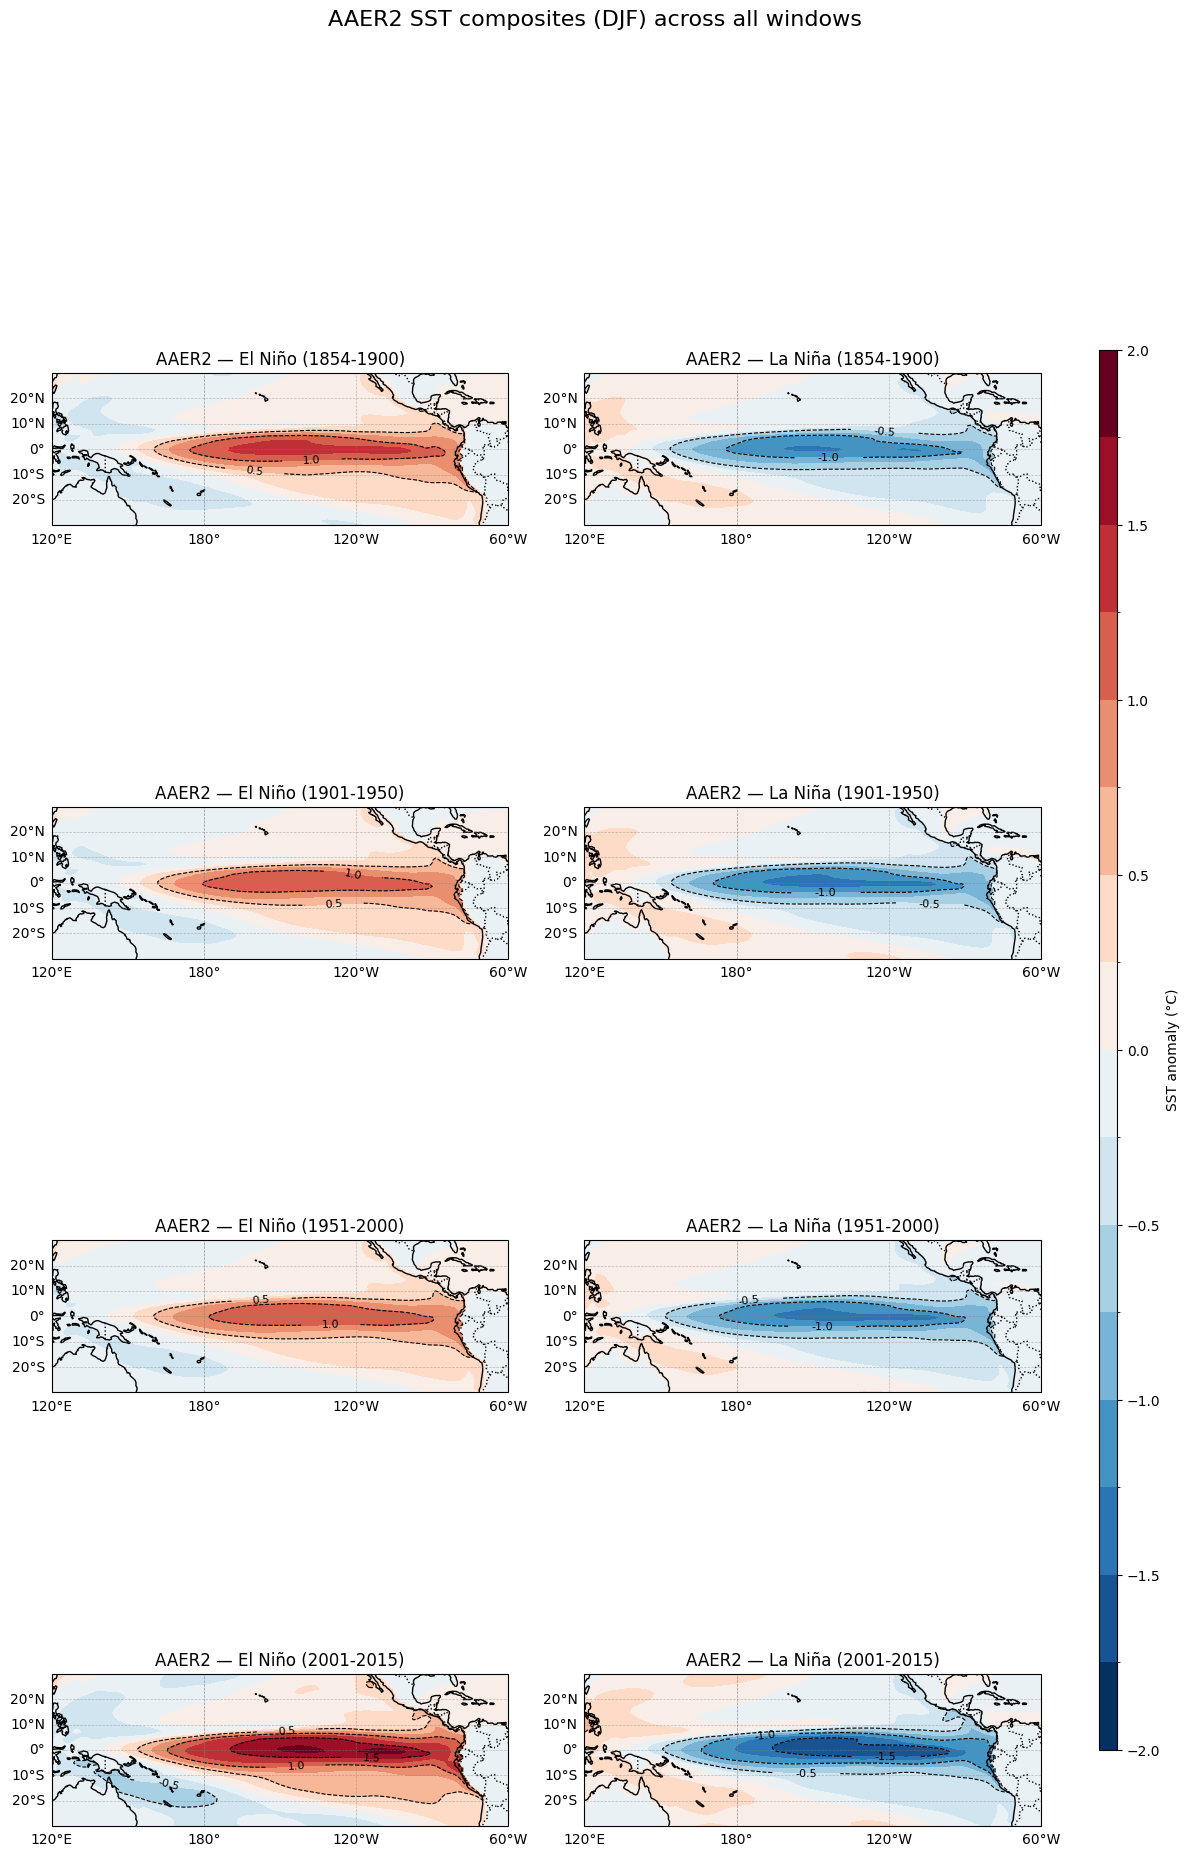

✅ Figure saved to: C:\Users\nickr\Desktop\Indexes Capstone\\composites_output\AAER2_composites_all_windows.png
✅ All combined composites saved to: C:\Users\nickr\Desktop\Indexes Capstone\\composites_output


In [37]:
# -------------------------
# Final composites dict used for plotting
# -------------------------
composites_dict = {
    "Observations": obs_composites,
    "LENS2": lens_mean_regridded,
    "GHG2": ghg_mean,
    "AAER2": aaer_mean,
}

print("Ready to plot. keys:", list(composites_dict.keys()))

# -------------------------
# Mapping short keys to full labels for display
# -------------------------
phase_labels_map = {
    "El": "El Niño",
    "La": "La Niña"
}

# -------------------------
# Plotting loop (one figure per experiment with 4 stacked windows)
# -------------------------
for exp_name, exp_mean in composites_dict.items():
    print("Plotting:", exp_name)
    fig, axes = plt.subplots(
        nrows=len(windows), ncols=2,
        figsize=(12, 20),
        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}
    )

    last_artist = None

    for row_idx, window in enumerate(windows):
        start, end = window
        for col_idx, phase_key in enumerate(['El', 'La']):
            ax = axes[row_idx, col_idx]
            comp = exp_mean.get(window, {}).get(phase_key) if isinstance(exp_mean, dict) else None

            if comp is None:
                ax.text(0.5, 0.5, f"No composite data\n({phase_labels_map[phase_key]})",
                        transform=ax.transAxes, ha='center', va='center')
                ax.set_extent(plot_extent, crs=ccrs.PlateCarree())
                ax.coastlines()
                continue

            # collapsing non-spatial dims
            non_spatial_dims = [d for d in comp.dims if d not in ['lat','lon','nlat','nlon']]
            comp2d = comp.mean(dim=non_spatial_dims, skipna=True) if non_spatial_dims else comp

            # identifying lat/lon coords
            if 'lat' in comp2d.coords and comp2d['lat'].ndim == 1:
                lat_name, lon_name = 'lat', 'lon'
            else:
                lat_name = 'lat' if 'lat' in comp2d.coords else ('TLAT' if 'TLAT' in comp2d.coords else None)
                lon_name = 'lon' if 'lon' in comp2d.coords else ('TLONG' if 'TLONG' in comp2d.coords else None)

            try:
                if comp2d[lat_name].ndim == 2 or comp2d[lon_name].ndim == 2:
                    mesh = ax.pcolormesh(comp2d[lon_name], comp2d[lat_name], comp2d.values,
                                         transform=ccrs.PlateCarree(), shading='auto')
                    last_artist = mesh
                else:
                    im = comp2d.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                                              x=lon_name, y=lat_name, levels=levels, cmap=cmap,
                                              add_colorbar=False)
                    last_artist = im
                    cs = comp2d.plot.contour(ax=ax, transform=ccrs.PlateCarree(),
                                             x=lon_name, y=lat_name, levels=contour_levels,
                                             colors='black', linewidths=0.8, linestyles='--',
                                             add_colorbar=False)
                    ax.clabel(cs, inline=True, fontsize=8, fmt="%.1f")
            except Exception as e:
                ax.text(0.5, 0.5, f"Plot failed:\n{e}", transform=ax.transAxes, ha='center', va='center')
                ax.coastlines()
                continue

            ax.coastlines()
            ax.add_feature(cfeature.BORDERS, linestyle=':')
            ax.set_extent(plot_extent, crs=ccrs.PlateCarree())
            display_label = phase_labels_map.get(phase_key, phase_key)
            ax.set_title(f"{exp_name} — {display_label} ({start}-{end})")
            gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False

    # shared colorbar
    if last_artist is not None:
        cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
        cb = plt.colorbar(last_artist, cax=cax, orientation='vertical', ticks=np.arange(-2, 2.5, 0.5))
        cb.set_label('SST anomaly (°C)')

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.suptitle(f"{exp_name} SST composites (DJF) across all windows", fontsize=16, y=1.02)

    fname = os.path.join(out_dir, f"{exp_name}_composites_all_windows.png")

    # --- Saving figure to directory BEFORE showing ---
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    print(f"✅ Figure saved to: {fname}")

print("✅ All combined composites saved to:", out_dir)